## 2. Modeling
we showed how to use siGra step by step

In [7]:
import argparse
import pandas as pd
import os
import scanpy as sc
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np
import cv2
import torchvision.transforms as transforms
from utils import Cal_Spatial_Net, Stats_Spatial_Net, _hungarian_match, seed_everything
from train_transformer import train_img, test_img
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt
import random
from scipy.optimize import linear_sum_assignment

os.environ['PYTHONHASHSEED'] = '1234'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

### 2.1 define hyperparameters

In [155]:
data_root = '../data/DLPFC'

# AAE:200 wo/decode:80  all:550 n:4
# sample name
sample_name = '151676'
n_clusters = 5 if sample_name in ['151669', '151670', '151671', '151672'] else 7
adata = sc.read_visium(f"{data_root}/{sample_name}")
print(adata)
adata.var_names_make_unique()

df_meta = pd.read_csv(f"{data_root}/{sample_name}/metadata.tsv", sep='\t')
adata.obs['layer_guess'] = df_meta['layer_guess']

/tmp/ipykernel_522051/2763885759.py:7: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(f"{data_root}/{sample_name}")
/data/hgh/anaconda3/envs/sigra/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/hgh/anaconda3/envs/sigra/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In [156]:
root = data_root
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

ncluster = len(set(adata.obs['layer_guess']))

img = cv2.imread(os.path.join(root, sample_name, f'spatial/{sample_name}_full_image.tif'))
use_gray = 1
if use_gray:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
transform = transforms.ToTensor()
img = transform(img)

patchs = []
for coor in adata.obsm['spatial']:
    py, px = coor
    img_p = img[:, px-25:px+25, py-25:py+25].flatten()
    patchs.append(img_p)
patchs = np.stack(patchs)
df = pd.DataFrame(patchs, index=adata.obs.index)
adata.obsm['imgs'] = df

Cal_Spatial_Net(adata, rad_cutoff=150)
Stats_Spatial_Net(adata)

------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


/data/hgh/projects/SiGra/SiGra_model/utils.py:246: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/data/hgh/projects/SiGra/SiGra_model/utils.py:246: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))


In [157]:
adata,res = train_img(adata, hidden_dims=[512, 30],  n_epochs=2000, save_loss=True, 
            lr=1e-3, random_seed=2025, save_path="./weight", ncluster=n_clusters, repeat=1, use_combine=0, use_img_loss=1)

Size of Input:  (3460, 33538)


  0%|          | 0/2000 [00:00<?, ?it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


  0%|          | 3/2000 [00:00<06:52,  4.84it/s]

use img to build reconstrauction loss


  0%|          | 4/2000 [00:00<08:33,  3.89it/s]

use img to build reconstrauction loss


  0%|          | 5/2000 [00:01<09:31,  3.49it/s]

use img to build reconstrauction loss


  0%|          | 6/2000 [00:01<10:08,  3.28it/s]

use img to build reconstrauction loss


  0%|          | 7/2000 [00:01<10:31,  3.16it/s]

use img to build reconstrauction loss


  0%|          | 8/2000 [00:02<10:46,  3.08it/s]

use img to build reconstrauction loss


  0%|          | 9/2000 [00:02<10:57,  3.03it/s]

use img to build reconstrauction loss


  0%|          | 10/2000 [00:02<11:04,  3.00it/s]

use img to build reconstrauction loss


  1%|          | 11/2000 [00:03<11:08,  2.97it/s]

use img to build reconstrauction loss


  1%|          | 12/2000 [00:03<11:13,  2.95it/s]

use img to build reconstrauction loss


  1%|          | 13/2000 [00:04<11:15,  2.94it/s]

use img to build reconstrauction loss


  1%|          | 14/2000 [00:04<11:16,  2.93it/s]

use img to build reconstrauction loss


  1%|          | 15/2000 [00:04<11:17,  2.93it/s]

use img to build reconstrauction loss


  1%|          | 16/2000 [00:05<11:19,  2.92it/s]

use img to build reconstrauction loss


  1%|          | 17/2000 [00:05<11:19,  2.92it/s]

use img to build reconstrauction loss


  1%|          | 18/2000 [00:05<11:19,  2.92it/s]

use img to build reconstrauction loss


  1%|          | 19/2000 [00:06<11:19,  2.91it/s]

use img to build reconstrauction loss


  1%|          | 20/2000 [00:06<11:19,  2.91it/s]

use img to build reconstrauction loss


  1%|          | 21/2000 [00:06<11:18,  2.92it/s]

use img to build reconstrauction loss


  1%|          | 22/2000 [00:07<11:17,  2.92it/s]

use img to build reconstrauction loss


  1%|          | 23/2000 [00:07<11:17,  2.92it/s]

use img to build reconstrauction loss


  1%|          | 24/2000 [00:07<11:17,  2.92it/s]

use img to build reconstrauction loss


  1%|▏         | 25/2000 [00:08<11:17,  2.91it/s]

use img to build reconstrauction loss


  1%|▏         | 26/2000 [00:08<11:17,  2.91it/s]

use img to build reconstrauction loss


  1%|▏         | 27/2000 [00:08<11:17,  2.91it/s]

use img to build reconstrauction loss


  1%|▏         | 28/2000 [00:09<11:17,  2.91it/s]

use img to build reconstrauction loss


  1%|▏         | 29/2000 [00:09<11:17,  2.91it/s]

use img to build reconstrauction loss


  2%|▏         | 30/2000 [00:09<11:17,  2.91it/s]

use img to build reconstrauction loss


  2%|▏         | 31/2000 [00:10<11:17,  2.91it/s]

use img to build reconstrauction loss


  2%|▏         | 32/2000 [00:10<11:17,  2.90it/s]

use img to build reconstrauction loss


  2%|▏         | 33/2000 [00:10<11:17,  2.90it/s]

use img to build reconstrauction loss


  2%|▏         | 34/2000 [00:11<11:16,  2.91it/s]

use img to build reconstrauction loss


  2%|▏         | 35/2000 [00:11<11:16,  2.91it/s]

use img to build reconstrauction loss


  2%|▏         | 36/2000 [00:11<11:15,  2.91it/s]

use img to build reconstrauction loss


  2%|▏         | 37/2000 [00:12<11:16,  2.90it/s]

use img to build reconstrauction loss


  2%|▏         | 38/2000 [00:12<11:15,  2.90it/s]

use img to build reconstrauction loss


  2%|▏         | 39/2000 [00:12<11:15,  2.90it/s]

use img to build reconstrauction loss


  2%|▏         | 40/2000 [00:13<11:15,  2.90it/s]

use img to build reconstrauction loss


  2%|▏         | 41/2000 [00:13<11:14,  2.91it/s]

use img to build reconstrauction loss


  2%|▏         | 42/2000 [00:13<11:14,  2.90it/s]

use img to build reconstrauction loss


  2%|▏         | 43/2000 [00:14<11:13,  2.91it/s]

use img to build reconstrauction loss


  2%|▏         | 44/2000 [00:14<11:12,  2.91it/s]

use img to build reconstrauction loss


  2%|▏         | 45/2000 [00:15<11:12,  2.91it/s]

use img to build reconstrauction loss


  2%|▏         | 46/2000 [00:15<11:11,  2.91it/s]

use img to build reconstrauction loss


  2%|▏         | 47/2000 [00:15<11:11,  2.91it/s]

use img to build reconstrauction loss


  2%|▏         | 48/2000 [00:16<11:11,  2.91it/s]

use img to build reconstrauction loss


  2%|▏         | 49/2000 [00:16<11:11,  2.91it/s]

use img to build reconstrauction loss


  2%|▎         | 50/2000 [00:16<11:10,  2.91it/s]

use img to build reconstrauction loss


  3%|▎         | 51/2000 [00:17<11:11,  2.90it/s]

use img to build reconstrauction loss


  3%|▎         | 52/2000 [00:17<11:11,  2.90it/s]

use img to build reconstrauction loss


  3%|▎         | 53/2000 [00:17<11:11,  2.90it/s]

use img to build reconstrauction loss


  3%|▎         | 54/2000 [00:18<11:11,  2.90it/s]

use img to build reconstrauction loss


  3%|▎         | 55/2000 [00:18<11:11,  2.90it/s]

use img to build reconstrauction loss


  3%|▎         | 56/2000 [00:18<11:11,  2.90it/s]

use img to build reconstrauction loss


  3%|▎         | 57/2000 [00:19<11:11,  2.89it/s]

use img to build reconstrauction loss


  3%|▎         | 58/2000 [00:19<11:11,  2.89it/s]

use img to build reconstrauction loss


  3%|▎         | 59/2000 [00:19<11:10,  2.90it/s]

use img to build reconstrauction loss


  3%|▎         | 60/2000 [00:20<11:09,  2.90it/s]

use img to build reconstrauction loss


  3%|▎         | 61/2000 [00:20<11:08,  2.90it/s]

use img to build reconstrauction loss


  3%|▎         | 62/2000 [00:20<11:08,  2.90it/s]

use img to build reconstrauction loss


  3%|▎         | 63/2000 [00:21<11:08,  2.90it/s]

use img to build reconstrauction loss


  3%|▎         | 64/2000 [00:21<11:08,  2.90it/s]

use img to build reconstrauction loss


  3%|▎         | 65/2000 [00:21<11:08,  2.89it/s]

use img to build reconstrauction loss


  3%|▎         | 66/2000 [00:22<11:08,  2.89it/s]

use img to build reconstrauction loss


  3%|▎         | 67/2000 [00:22<11:08,  2.89it/s]

use img to build reconstrauction loss


  3%|▎         | 68/2000 [00:22<11:08,  2.89it/s]

use img to build reconstrauction loss


  3%|▎         | 69/2000 [00:23<11:07,  2.89it/s]

use img to build reconstrauction loss


  4%|▎         | 70/2000 [00:23<11:06,  2.90it/s]

use img to build reconstrauction loss


  4%|▎         | 71/2000 [00:23<11:06,  2.89it/s]

use img to build reconstrauction loss


  4%|▎         | 72/2000 [00:24<11:06,  2.89it/s]

use img to build reconstrauction loss


  4%|▎         | 73/2000 [00:24<11:07,  2.89it/s]

use img to build reconstrauction loss


  4%|▎         | 74/2000 [00:25<11:07,  2.89it/s]

use img to build reconstrauction loss


  4%|▍         | 75/2000 [00:25<11:07,  2.89it/s]

use img to build reconstrauction loss


  4%|▍         | 76/2000 [00:25<11:07,  2.88it/s]

use img to build reconstrauction loss


  4%|▍         | 77/2000 [00:26<11:06,  2.88it/s]

use img to build reconstrauction loss


  4%|▍         | 78/2000 [00:26<11:05,  2.89it/s]

use img to build reconstrauction loss


  4%|▍         | 79/2000 [00:26<11:06,  2.88it/s]

use img to build reconstrauction loss


  4%|▍         | 80/2000 [00:27<11:06,  2.88it/s]

use img to build reconstrauction loss


  4%|▍         | 81/2000 [00:27<11:06,  2.88it/s]

use img to build reconstrauction loss


  4%|▍         | 82/2000 [00:27<11:05,  2.88it/s]

use img to build reconstrauction loss


  4%|▍         | 83/2000 [00:28<11:04,  2.88it/s]

use img to build reconstrauction loss


  4%|▍         | 84/2000 [00:28<11:04,  2.88it/s]

use img to build reconstrauction loss


  4%|▍         | 85/2000 [00:28<11:04,  2.88it/s]

use img to build reconstrauction loss


  4%|▍         | 86/2000 [00:29<11:04,  2.88it/s]

use img to build reconstrauction loss


  4%|▍         | 87/2000 [00:29<11:04,  2.88it/s]

use img to build reconstrauction loss


  4%|▍         | 88/2000 [00:29<11:03,  2.88it/s]

use img to build reconstrauction loss


  4%|▍         | 89/2000 [00:30<11:03,  2.88it/s]

use img to build reconstrauction loss


  4%|▍         | 90/2000 [00:30<11:02,  2.88it/s]

use img to build reconstrauction loss


  5%|▍         | 91/2000 [00:30<11:03,  2.88it/s]

use img to build reconstrauction loss


  5%|▍         | 92/2000 [00:31<11:03,  2.88it/s]

use img to build reconstrauction loss


  5%|▍         | 93/2000 [00:31<11:02,  2.88it/s]

use img to build reconstrauction loss


  5%|▍         | 94/2000 [00:31<11:01,  2.88it/s]

use img to build reconstrauction loss


  5%|▍         | 95/2000 [00:32<11:01,  2.88it/s]

use img to build reconstrauction loss


  5%|▍         | 96/2000 [00:32<11:00,  2.88it/s]

use img to build reconstrauction loss


  5%|▍         | 97/2000 [00:33<11:00,  2.88it/s]

use img to build reconstrauction loss


  5%|▍         | 98/2000 [00:33<11:00,  2.88it/s]

use img to build reconstrauction loss


  5%|▍         | 99/2000 [00:33<11:00,  2.88it/s]

use img to build reconstrauction loss


  5%|▌         | 100/2000 [00:34<10:59,  2.88it/s]

use img to build reconstrauction loss


  5%|▌         | 101/2000 [00:34<10:59,  2.88it/s]

use img to build reconstrauction loss


  5%|▌         | 102/2000 [00:34<11:00,  2.88it/s]

use img to build reconstrauction loss


  5%|▌         | 103/2000 [00:35<10:59,  2.87it/s]

use img to build reconstrauction loss


  5%|▌         | 104/2000 [00:35<10:58,  2.88it/s]

use img to build reconstrauction loss


  5%|▌         | 105/2000 [00:35<10:57,  2.88it/s]

use img to build reconstrauction loss


  5%|▌         | 106/2000 [00:36<10:57,  2.88it/s]

use img to build reconstrauction loss


  5%|▌         | 107/2000 [00:36<10:58,  2.88it/s]

use img to build reconstrauction loss


  5%|▌         | 108/2000 [00:36<10:57,  2.88it/s]

use img to build reconstrauction loss


  5%|▌         | 109/2000 [00:37<10:57,  2.88it/s]

use img to build reconstrauction loss


  6%|▌         | 110/2000 [00:37<10:56,  2.88it/s]

use img to build reconstrauction loss


  6%|▌         | 111/2000 [00:37<10:57,  2.87it/s]

use img to build reconstrauction loss


  6%|▌         | 112/2000 [00:38<10:57,  2.87it/s]

use img to build reconstrauction loss


  6%|▌         | 113/2000 [00:38<10:57,  2.87it/s]

use img to build reconstrauction loss


  6%|▌         | 114/2000 [00:38<10:56,  2.87it/s]

use img to build reconstrauction loss


  6%|▌         | 115/2000 [00:39<10:56,  2.87it/s]

use img to build reconstrauction loss


  6%|▌         | 116/2000 [00:39<10:56,  2.87it/s]

use img to build reconstrauction loss


  6%|▌         | 117/2000 [00:39<10:55,  2.87it/s]

use img to build reconstrauction loss


  6%|▌         | 118/2000 [00:40<10:54,  2.88it/s]

use img to build reconstrauction loss


  6%|▌         | 119/2000 [00:40<10:54,  2.87it/s]

use img to build reconstrauction loss


  6%|▌         | 120/2000 [00:41<10:55,  2.87it/s]

use img to build reconstrauction loss


  6%|▌         | 121/2000 [00:41<10:55,  2.87it/s]

use img to build reconstrauction loss


  6%|▌         | 122/2000 [00:41<10:54,  2.87it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


  6%|▌         | 124/2000 [00:42<10:55,  2.86it/s]

use img to build reconstrauction loss


  6%|▋         | 125/2000 [00:42<10:54,  2.86it/s]

use img to build reconstrauction loss


  6%|▋         | 126/2000 [00:43<10:54,  2.86it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


  6%|▋         | 128/2000 [00:43<10:53,  2.86it/s]

use img to build reconstrauction loss


  6%|▋         | 129/2000 [00:44<10:52,  2.87it/s]

use img to build reconstrauction loss


  6%|▋         | 130/2000 [00:44<10:52,  2.87it/s]

use img to build reconstrauction loss


  7%|▋         | 131/2000 [00:44<10:51,  2.87it/s]

use img to build reconstrauction loss


  7%|▋         | 132/2000 [00:45<10:52,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 133/2000 [00:45<10:51,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 134/2000 [00:45<10:51,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 135/2000 [00:46<10:51,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 136/2000 [00:46<10:51,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 137/2000 [00:46<10:50,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 138/2000 [00:47<10:50,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 139/2000 [00:47<10:50,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 140/2000 [00:48<10:50,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 141/2000 [00:48<10:49,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 142/2000 [00:48<10:49,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 143/2000 [00:49<10:48,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 144/2000 [00:49<10:48,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 145/2000 [00:49<10:47,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 146/2000 [00:50<10:47,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 147/2000 [00:50<10:48,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 148/2000 [00:50<10:47,  2.86it/s]

use img to build reconstrauction loss


  7%|▋         | 149/2000 [00:51<10:47,  2.86it/s]

use img to build reconstrauction loss


  8%|▊         | 150/2000 [00:51<10:47,  2.86it/s]

use img to build reconstrauction loss


  8%|▊         | 151/2000 [00:51<10:46,  2.86it/s]

use img to build reconstrauction loss


  8%|▊         | 152/2000 [00:52<10:46,  2.86it/s]

use img to build reconstrauction loss


  8%|▊         | 153/2000 [00:52<10:45,  2.86it/s]

use img to build reconstrauction loss


  8%|▊         | 154/2000 [00:52<10:45,  2.86it/s]

use img to build reconstrauction loss


  8%|▊         | 155/2000 [00:53<10:45,  2.86it/s]

use img to build reconstrauction loss


  8%|▊         | 156/2000 [00:53<10:45,  2.86it/s]

use img to build reconstrauction loss


  8%|▊         | 157/2000 [00:53<10:44,  2.86it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


  8%|▊         | 159/2000 [00:54<10:44,  2.85it/s]

use img to build reconstrauction loss


  8%|▊         | 160/2000 [00:55<10:44,  2.85it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


  8%|▊         | 162/2000 [00:55<10:43,  2.86it/s]

use img to build reconstrauction loss


  8%|▊         | 163/2000 [00:56<10:43,  2.86it/s]

use img to build reconstrauction loss


  8%|▊         | 164/2000 [00:56<10:42,  2.86it/s]

use img to build reconstrauction loss


  8%|▊         | 165/2000 [00:56<10:42,  2.86it/s]

use img to build reconstrauction loss


  8%|▊         | 166/2000 [00:57<10:42,  2.86it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


  8%|▊         | 168/2000 [00:57<10:41,  2.85it/s]

use img to build reconstrauction loss


  8%|▊         | 169/2000 [00:58<10:41,  2.85it/s]

use img to build reconstrauction loss


  8%|▊         | 170/2000 [00:58<10:41,  2.85it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


  9%|▊         | 171/2000 [00:58<10:42,  2.85it/s]

use img to build reconstrauction loss


  9%|▊         | 173/2000 [00:59<10:40,  2.85it/s]

use img to build reconstrauction loss


  9%|▊         | 174/2000 [00:59<10:40,  2.85it/s]

use img to build reconstrauction loss


  9%|▉         | 175/2000 [01:00<10:40,  2.85it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


  9%|▉         | 177/2000 [01:00<10:39,  2.85it/s]

use img to build reconstrauction loss


  9%|▉         | 178/2000 [01:01<10:38,  2.85it/s]

use img to build reconstrauction loss


  9%|▉         | 179/2000 [01:01<10:37,  2.85it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


  9%|▉         | 180/2000 [01:02<10:38,  2.85it/s]

use img to build reconstrauction loss


  9%|▉         | 181/2000 [01:02<10:37,  2.85it/s]

use img to build reconstrauction loss


  9%|▉         | 183/2000 [01:03<10:37,  2.85it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


  9%|▉         | 185/2000 [01:03<10:36,  2.85it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


  9%|▉         | 187/2000 [01:04<10:35,  2.85it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


  9%|▉         | 189/2000 [01:05<10:35,  2.85it/s]

use img to build reconstrauction loss


 10%|▉         | 190/2000 [01:05<10:34,  2.85it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 10%|▉         | 192/2000 [01:06<10:35,  2.85it/s]

use img to build reconstrauction loss


 10%|▉         | 193/2000 [01:06<10:34,  2.85it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 10%|▉         | 195/2000 [01:07<10:34,  2.85it/s]

use img to build reconstrauction loss


 10%|▉         | 196/2000 [01:07<10:33,  2.85it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 10%|▉         | 198/2000 [01:08<10:32,  2.85it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 10%|▉         | 199/2000 [01:08<10:33,  2.84it/s]

use img to build reconstrauction loss


 10%|█         | 200/2000 [01:09<10:32,  2.85it/s]

use img to build reconstrauction loss


 10%|█         | 202/2000 [01:09<10:32,  2.84it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 10%|█         | 203/2000 [01:10<10:31,  2.84it/s]

use img to build reconstrauction loss


 10%|█         | 204/2000 [01:10<10:32,  2.84it/s]

use img to build reconstrauction loss


 10%|█         | 206/2000 [01:11<10:30,  2.84it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 10%|█         | 207/2000 [01:11<10:30,  2.84it/s]

use img to build reconstrauction loss


 10%|█         | 208/2000 [01:11<10:30,  2.84it/s]

use img to build reconstrauction loss


 10%|█         | 209/2000 [01:12<10:29,  2.85it/s]

use img to build reconstrauction loss


 11%|█         | 211/2000 [01:12<10:28,  2.84it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 11%|█         | 212/2000 [01:13<10:28,  2.84it/s]

use img to build reconstrauction loss


 11%|█         | 214/2000 [01:13<10:27,  2.85it/s]

use img to build reconstrauction loss


 11%|█         | 215/2000 [01:14<10:26,  2.85it/s]

use img to build reconstrauction loss


 11%|█         | 216/2000 [01:14<10:26,  2.85it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 11%|█         | 217/2000 [01:15<10:27,  2.84it/s]

use img to build reconstrauction loss


 11%|█         | 219/2000 [01:15<10:26,  2.84it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 11%|█         | 220/2000 [01:16<10:25,  2.84it/s]

use img to build reconstrauction loss


 11%|█         | 221/2000 [01:16<10:25,  2.84it/s]

use img to build reconstrauction loss


 11%|█         | 222/2000 [01:16<10:25,  2.84it/s]

use img to build reconstrauction loss


 11%|█         | 223/2000 [01:17<10:24,  2.84it/s]

use img to build reconstrauction loss


 11%|█▏        | 225/2000 [01:17<10:24,  2.84it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 11%|█▏        | 226/2000 [01:18<10:24,  2.84it/s]

use img to build reconstrauction loss


 11%|█▏        | 227/2000 [01:18<10:24,  2.84it/s]

use img to build reconstrauction loss


 11%|█▏        | 228/2000 [01:18<10:23,  2.84it/s]

use img to build reconstrauction loss


 11%|█▏        | 229/2000 [01:19<10:24,  2.84it/s]

use img to build reconstrauction loss


 12%|█▏        | 230/2000 [01:19<10:23,  2.84it/s]

use img to build reconstrauction loss


 12%|█▏        | 232/2000 [01:20<10:22,  2.84it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 12%|█▏        | 233/2000 [01:20<10:21,  2.84it/s]

use img to build reconstrauction loss


 12%|█▏        | 234/2000 [01:20<10:22,  2.84it/s]

use img to build reconstrauction loss


 12%|█▏        | 235/2000 [01:21<10:21,  2.84it/s]

use img to build reconstrauction loss


 12%|█▏        | 237/2000 [01:22<10:20,  2.84it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 12%|█▏        | 238/2000 [01:22<10:20,  2.84it/s]

use img to build reconstrauction loss


 12%|█▏        | 239/2000 [01:22<10:20,  2.84it/s]

use img to build reconstrauction loss


 12%|█▏        | 240/2000 [01:23<10:20,  2.84it/s]

use img to build reconstrauction loss


 12%|█▏        | 241/2000 [01:23<10:19,  2.84it/s]

use img to build reconstrauction loss


 12%|█▏        | 242/2000 [01:23<10:19,  2.84it/s]

use img to build reconstrauction loss


 12%|█▏        | 243/2000 [01:24<10:19,  2.84it/s]

use img to build reconstrauction loss


 12%|█▏        | 244/2000 [01:24<10:18,  2.84it/s]

use img to build reconstrauction loss


 12%|█▏        | 245/2000 [01:24<10:18,  2.84it/s]

use img to build reconstrauction loss


 12%|█▏        | 246/2000 [01:25<10:18,  2.84it/s]

use img to build reconstrauction loss


 12%|█▏        | 248/2000 [01:25<10:17,  2.84it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 12%|█▏        | 249/2000 [01:26<10:17,  2.84it/s]

use img to build reconstrauction loss


 12%|█▎        | 250/2000 [01:26<10:16,  2.84it/s]

use img to build reconstrauction loss


 13%|█▎        | 251/2000 [01:26<10:16,  2.84it/s]

use img to build reconstrauction loss


 13%|█▎        | 253/2000 [01:27<10:15,  2.84it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 13%|█▎        | 254/2000 [01:28<10:15,  2.84it/s]

use img to build reconstrauction loss


 13%|█▎        | 255/2000 [01:28<10:15,  2.84it/s]

use img to build reconstrauction loss


 13%|█▎        | 256/2000 [01:28<10:15,  2.84it/s]

use img to build reconstrauction loss


 13%|█▎        | 257/2000 [01:29<10:14,  2.83it/s]

use img to build reconstrauction loss


 13%|█▎        | 258/2000 [01:29<10:14,  2.83it/s]

use img to build reconstrauction loss


 13%|█▎        | 259/2000 [01:29<10:14,  2.83it/s]

use img to build reconstrauction loss


 13%|█▎        | 260/2000 [01:30<10:14,  2.83it/s]

use img to build reconstrauction loss


 13%|█▎        | 261/2000 [01:30<10:13,  2.83it/s]

use img to build reconstrauction loss


 13%|█▎        | 262/2000 [01:30<10:13,  2.83it/s]

use img to build reconstrauction loss


 13%|█▎        | 263/2000 [01:31<10:13,  2.83it/s]

use img to build reconstrauction loss


 13%|█▎        | 264/2000 [01:31<10:12,  2.83it/s]

use img to build reconstrauction loss


 13%|█▎        | 265/2000 [01:31<10:12,  2.83it/s]

use img to build reconstrauction loss


 13%|█▎        | 266/2000 [01:32<10:11,  2.84it/s]

use img to build reconstrauction loss


 13%|█▎        | 267/2000 [01:32<10:11,  2.84it/s]

use img to build reconstrauction loss


 13%|█▎        | 268/2000 [01:32<10:10,  2.84it/s]

use img to build reconstrauction loss


 13%|█▎        | 269/2000 [01:33<10:10,  2.84it/s]

use img to build reconstrauction loss


 14%|█▎        | 270/2000 [01:33<10:10,  2.84it/s]

use img to build reconstrauction loss


 14%|█▎        | 271/2000 [01:34<10:10,  2.83it/s]

use img to build reconstrauction loss


 14%|█▎        | 272/2000 [01:34<10:09,  2.83it/s]

use img to build reconstrauction loss


 14%|█▎        | 273/2000 [01:34<10:09,  2.83it/s]

use img to build reconstrauction loss


 14%|█▎        | 274/2000 [01:35<10:09,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 275/2000 [01:35<10:09,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 276/2000 [01:35<10:08,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 277/2000 [01:36<10:08,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 278/2000 [01:36<10:08,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 279/2000 [01:36<10:07,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 280/2000 [01:37<10:07,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 281/2000 [01:37<10:06,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 282/2000 [01:37<10:06,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 283/2000 [01:38<10:06,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 284/2000 [01:38<10:06,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 285/2000 [01:38<10:05,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 286/2000 [01:39<10:05,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 287/2000 [01:39<10:04,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 288/2000 [01:40<10:04,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 289/2000 [01:40<10:04,  2.83it/s]

use img to build reconstrauction loss


 14%|█▍        | 290/2000 [01:40<10:04,  2.83it/s]

use img to build reconstrauction loss


 15%|█▍        | 291/2000 [01:41<10:03,  2.83it/s]

use img to build reconstrauction loss


 15%|█▍        | 292/2000 [01:41<10:04,  2.83it/s]

use img to build reconstrauction loss


 15%|█▍        | 293/2000 [01:41<10:03,  2.83it/s]

use img to build reconstrauction loss


 15%|█▍        | 294/2000 [01:42<10:03,  2.83it/s]

use img to build reconstrauction loss


 15%|█▍        | 295/2000 [01:42<10:02,  2.83it/s]

use img to build reconstrauction loss


 15%|█▍        | 296/2000 [01:42<10:02,  2.83it/s]

use img to build reconstrauction loss


 15%|█▍        | 297/2000 [01:43<10:02,  2.83it/s]

use img to build reconstrauction loss


 15%|█▍        | 298/2000 [01:43<10:01,  2.83it/s]

use img to build reconstrauction loss


 15%|█▍        | 299/2000 [01:43<10:01,  2.83it/s]

use img to build reconstrauction loss


 15%|█▌        | 300/2000 [01:44<10:01,  2.82it/s]

use img to build reconstrauction loss


 15%|█▌        | 301/2000 [01:44<10:00,  2.83it/s]

use img to build reconstrauction loss


 15%|█▌        | 302/2000 [01:45<10:00,  2.83it/s]

use img to build reconstrauction loss


 15%|█▌        | 303/2000 [01:45<09:59,  2.83it/s]

use img to build reconstrauction loss


 15%|█▌        | 305/2000 [01:46<09:57,  2.84it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 15%|█▌        | 306/2000 [01:46<09:57,  2.83it/s]

use img to build reconstrauction loss


 15%|█▌        | 307/2000 [01:46<09:57,  2.83it/s]

use img to build reconstrauction loss


 15%|█▌        | 308/2000 [01:47<09:57,  2.83it/s]

use img to build reconstrauction loss


 16%|█▌        | 310/2000 [01:47<09:55,  2.84it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 16%|█▌        | 311/2000 [01:48<09:55,  2.83it/s]

use img to build reconstrauction loss


 16%|█▌        | 312/2000 [01:48<09:55,  2.84it/s]

use img to build reconstrauction loss


 16%|█▌        | 314/2000 [01:49<09:54,  2.84it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 16%|█▌        | 315/2000 [01:49<09:54,  2.83it/s]

use img to build reconstrauction loss


 16%|█▌        | 316/2000 [01:49<09:54,  2.83it/s]

use img to build reconstrauction loss


 16%|█▌        | 317/2000 [01:50<09:53,  2.83it/s]

use img to build reconstrauction loss


 16%|█▌        | 319/2000 [01:50<09:53,  2.83it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 16%|█▌        | 320/2000 [01:51<09:53,  2.83it/s]

use img to build reconstrauction loss


 16%|█▌        | 321/2000 [01:51<09:53,  2.83it/s]

use img to build reconstrauction loss


 16%|█▌        | 322/2000 [01:52<09:53,  2.83it/s]

use img to build reconstrauction loss


 16%|█▌        | 323/2000 [01:52<09:53,  2.83it/s]

use img to build reconstrauction loss


 16%|█▌        | 324/2000 [01:52<09:52,  2.83it/s]

use img to build reconstrauction loss


 16%|█▋        | 325/2000 [01:53<09:52,  2.83it/s]

use img to build reconstrauction loss


 16%|█▋        | 326/2000 [01:53<09:51,  2.83it/s]

use img to build reconstrauction loss


 16%|█▋        | 327/2000 [01:53<09:51,  2.83it/s]

use img to build reconstrauction loss


 16%|█▋        | 328/2000 [01:54<09:50,  2.83it/s]

use img to build reconstrauction loss


 16%|█▋        | 329/2000 [01:54<09:50,  2.83it/s]

use img to build reconstrauction loss


 16%|█▋        | 330/2000 [01:54<09:50,  2.83it/s]

use img to build reconstrauction loss


 17%|█▋        | 331/2000 [01:55<09:50,  2.83it/s]

use img to build reconstrauction loss


 17%|█▋        | 332/2000 [01:55<09:50,  2.83it/s]

use img to build reconstrauction loss


 17%|█▋        | 333/2000 [01:55<09:50,  2.82it/s]

use img to build reconstrauction loss


 17%|█▋        | 334/2000 [01:56<09:49,  2.82it/s]

use img to build reconstrauction loss


 17%|█▋        | 335/2000 [01:56<09:49,  2.82it/s]

use img to build reconstrauction loss


 17%|█▋        | 336/2000 [01:57<09:49,  2.82it/s]

use img to build reconstrauction loss


 17%|█▋        | 337/2000 [01:57<09:48,  2.82it/s]

use img to build reconstrauction loss


 17%|█▋        | 338/2000 [01:57<09:48,  2.83it/s]

use img to build reconstrauction loss


 17%|█▋        | 339/2000 [01:58<09:48,  2.82it/s]

use img to build reconstrauction loss


 17%|█▋        | 340/2000 [01:58<09:47,  2.82it/s]

use img to build reconstrauction loss


 17%|█▋        | 341/2000 [01:58<09:47,  2.82it/s]

use img to build reconstrauction loss


 17%|█▋        | 342/2000 [01:59<09:46,  2.83it/s]

use img to build reconstrauction loss


 17%|█▋        | 343/2000 [01:59<09:46,  2.82it/s]

use img to build reconstrauction loss


 17%|█▋        | 344/2000 [01:59<09:46,  2.82it/s]

use img to build reconstrauction loss


 17%|█▋        | 345/2000 [02:00<09:45,  2.82it/s]

use img to build reconstrauction loss


 17%|█▋        | 346/2000 [02:00<09:45,  2.83it/s]

use img to build reconstrauction loss


 17%|█▋        | 347/2000 [02:00<09:44,  2.83it/s]

use img to build reconstrauction loss


 17%|█▋        | 348/2000 [02:01<09:44,  2.83it/s]

use img to build reconstrauction loss


 17%|█▋        | 349/2000 [02:01<09:44,  2.83it/s]

use img to build reconstrauction loss


 18%|█▊        | 350/2000 [02:01<09:44,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 351/2000 [02:02<09:43,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 352/2000 [02:02<09:43,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 353/2000 [02:03<09:43,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 354/2000 [02:03<09:42,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 355/2000 [02:03<09:43,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 356/2000 [02:04<09:42,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 357/2000 [02:04<09:41,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 358/2000 [02:04<09:41,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 359/2000 [02:05<09:41,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 360/2000 [02:05<09:40,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 361/2000 [02:05<09:40,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 362/2000 [02:06<09:39,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 363/2000 [02:06<09:40,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 364/2000 [02:06<09:39,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 365/2000 [02:07<09:39,  2.82it/s]

use img to build reconstrauction loss


 18%|█▊        | 366/2000 [02:07<09:38,  2.83it/s]

use img to build reconstrauction loss


 18%|█▊        | 367/2000 [02:07<09:37,  2.83it/s]

use img to build reconstrauction loss


 18%|█▊        | 368/2000 [02:08<09:36,  2.83it/s]

use img to build reconstrauction loss


 18%|█▊        | 369/2000 [02:08<09:36,  2.83it/s]

use img to build reconstrauction loss


 18%|█▊        | 370/2000 [02:09<09:36,  2.83it/s]

use img to build reconstrauction loss


 19%|█▊        | 371/2000 [02:09<09:36,  2.82it/s]

use img to build reconstrauction loss


 19%|█▊        | 372/2000 [02:09<09:36,  2.83it/s]

use img to build reconstrauction loss


 19%|█▊        | 373/2000 [02:10<09:36,  2.82it/s]

use img to build reconstrauction loss


 19%|█▊        | 374/2000 [02:10<09:35,  2.83it/s]

use img to build reconstrauction loss


 19%|█▉        | 375/2000 [02:10<09:35,  2.82it/s]

use img to build reconstrauction loss


 19%|█▉        | 376/2000 [02:11<09:34,  2.83it/s]

use img to build reconstrauction loss


 19%|█▉        | 377/2000 [02:11<09:34,  2.82it/s]

use img to build reconstrauction loss


 19%|█▉        | 378/2000 [02:11<09:34,  2.82it/s]

use img to build reconstrauction loss


 19%|█▉        | 379/2000 [02:12<09:34,  2.82it/s]

use img to build reconstrauction loss


 19%|█▉        | 381/2000 [02:12<09:33,  2.82it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 19%|█▉        | 382/2000 [02:13<09:33,  2.82it/s]

use img to build reconstrauction loss


 19%|█▉        | 383/2000 [02:13<09:33,  2.82it/s]

use img to build reconstrauction loss


 19%|█▉        | 384/2000 [02:14<09:33,  2.82it/s]

use img to build reconstrauction loss


 19%|█▉        | 385/2000 [02:14<09:32,  2.82it/s]

use img to build reconstrauction loss


 19%|█▉        | 386/2000 [02:14<09:32,  2.82it/s]

use img to build reconstrauction loss


 19%|█▉        | 387/2000 [02:15<09:32,  2.82it/s]

use img to build reconstrauction loss


 19%|█▉        | 388/2000 [02:15<09:31,  2.82it/s]

use img to build reconstrauction loss


 19%|█▉        | 389/2000 [02:15<09:30,  2.82it/s]

use img to build reconstrauction loss


 20%|█▉        | 390/2000 [02:16<09:30,  2.82it/s]

use img to build reconstrauction loss


 20%|█▉        | 391/2000 [02:16<09:30,  2.82it/s]

use img to build reconstrauction loss


 20%|█▉        | 392/2000 [02:16<09:30,  2.82it/s]

use img to build reconstrauction loss


 20%|█▉        | 393/2000 [02:17<09:30,  2.82it/s]

use img to build reconstrauction loss


 20%|█▉        | 394/2000 [02:17<09:29,  2.82it/s]

use img to build reconstrauction loss


 20%|█▉        | 395/2000 [02:17<09:29,  2.82it/s]

use img to build reconstrauction loss


 20%|█▉        | 396/2000 [02:18<09:28,  2.82it/s]

use img to build reconstrauction loss


 20%|█▉        | 397/2000 [02:18<09:28,  2.82it/s]

use img to build reconstrauction loss


 20%|█▉        | 398/2000 [02:18<09:27,  2.82it/s]

use img to build reconstrauction loss


 20%|█▉        | 399/2000 [02:19<09:26,  2.83it/s]

use img to build reconstrauction loss


 20%|██        | 400/2000 [02:19<09:25,  2.83it/s]

use img to build reconstrauction loss


 20%|██        | 401/2000 [02:20<09:25,  2.83it/s]

use img to build reconstrauction loss


 20%|██        | 402/2000 [02:20<09:25,  2.82it/s]

use img to build reconstrauction loss


 20%|██        | 403/2000 [02:20<09:25,  2.82it/s]

use img to build reconstrauction loss


 20%|██        | 404/2000 [02:21<09:25,  2.82it/s]

use img to build reconstrauction loss


 20%|██        | 405/2000 [02:21<09:25,  2.82it/s]

use img to build reconstrauction loss


 20%|██        | 406/2000 [02:21<09:25,  2.82it/s]

use img to build reconstrauction loss


 20%|██        | 407/2000 [02:22<09:24,  2.82it/s]

use img to build reconstrauction loss


 20%|██        | 409/2000 [02:22<09:23,  2.82it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 20%|██        | 410/2000 [02:23<09:24,  2.82it/s]

use img to build reconstrauction loss


 21%|██        | 411/2000 [02:23<09:23,  2.82it/s]

use img to build reconstrauction loss


 21%|██        | 412/2000 [02:23<09:23,  2.82it/s]

use img to build reconstrauction loss


 21%|██        | 413/2000 [02:24<09:22,  2.82it/s]

use img to build reconstrauction loss


 21%|██        | 414/2000 [02:24<09:22,  2.82it/s]

use img to build reconstrauction loss


 21%|██        | 415/2000 [02:24<09:21,  2.82it/s]

use img to build reconstrauction loss


 21%|██        | 416/2000 [02:25<09:21,  2.82it/s]

use img to build reconstrauction loss


 21%|██        | 417/2000 [02:25<09:20,  2.82it/s]

use img to build reconstrauction loss


 21%|██        | 418/2000 [02:26<09:20,  2.82it/s]

use img to build reconstrauction loss


 21%|██        | 419/2000 [02:26<09:20,  2.82it/s]

use img to build reconstrauction loss


 21%|██        | 420/2000 [02:26<09:20,  2.82it/s]

use img to build reconstrauction loss


 21%|██        | 421/2000 [02:27<09:20,  2.82it/s]

use img to build reconstrauction loss


 21%|██        | 422/2000 [02:27<09:19,  2.82it/s]

use img to build reconstrauction loss


 21%|██        | 423/2000 [02:27<09:19,  2.82it/s]

use img to build reconstrauction loss


 21%|██        | 424/2000 [02:28<09:18,  2.82it/s]

use img to build reconstrauction loss


 21%|██▏       | 425/2000 [02:28<09:19,  2.82it/s]

use img to build reconstrauction loss


 21%|██▏       | 426/2000 [02:28<09:18,  2.82it/s]

use img to build reconstrauction loss


 21%|██▏       | 427/2000 [02:29<09:18,  2.82it/s]

use img to build reconstrauction loss


 21%|██▏       | 428/2000 [02:29<09:17,  2.82it/s]

use img to build reconstrauction loss


 21%|██▏       | 429/2000 [02:29<09:17,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 430/2000 [02:30<09:17,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 431/2000 [02:30<09:16,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 432/2000 [02:31<09:16,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 433/2000 [02:31<09:16,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 434/2000 [02:31<09:16,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 435/2000 [02:32<09:15,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 436/2000 [02:32<09:15,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 437/2000 [02:32<09:14,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 438/2000 [02:33<09:14,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 439/2000 [02:33<09:14,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 440/2000 [02:33<09:13,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 441/2000 [02:34<09:13,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 442/2000 [02:34<09:13,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 443/2000 [02:34<09:12,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 444/2000 [02:35<09:12,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 445/2000 [02:35<09:12,  2.82it/s]

use img to build reconstrauction loss


 22%|██▏       | 446/2000 [02:36<09:12,  2.81it/s]

use img to build reconstrauction loss


 22%|██▏       | 447/2000 [02:36<09:11,  2.81it/s]

use img to build reconstrauction loss


 22%|██▏       | 448/2000 [02:36<09:11,  2.81it/s]

use img to build reconstrauction loss


 22%|██▏       | 449/2000 [02:37<09:11,  2.81it/s]

use img to build reconstrauction loss


 22%|██▎       | 450/2000 [02:37<09:10,  2.81it/s]

use img to build reconstrauction loss


 23%|██▎       | 451/2000 [02:37<09:10,  2.82it/s]

use img to build reconstrauction loss


 23%|██▎       | 452/2000 [02:38<09:09,  2.82it/s]

use img to build reconstrauction loss


 23%|██▎       | 453/2000 [02:38<09:10,  2.81it/s]

use img to build reconstrauction loss


 23%|██▎       | 454/2000 [02:38<09:09,  2.81it/s]

use img to build reconstrauction loss


 23%|██▎       | 455/2000 [02:39<09:08,  2.82it/s]

use img to build reconstrauction loss


 23%|██▎       | 456/2000 [02:39<09:08,  2.81it/s]

use img to build reconstrauction loss


 23%|██▎       | 457/2000 [02:39<09:07,  2.82it/s]

use img to build reconstrauction loss


 23%|██▎       | 458/2000 [02:40<09:08,  2.81it/s]

use img to build reconstrauction loss


 23%|██▎       | 459/2000 [02:40<09:07,  2.82it/s]

use img to build reconstrauction loss


 23%|██▎       | 460/2000 [02:40<09:06,  2.82it/s]

use img to build reconstrauction loss


 23%|██▎       | 461/2000 [02:41<09:07,  2.81it/s]

use img to build reconstrauction loss


 23%|██▎       | 462/2000 [02:41<09:06,  2.82it/s]

use img to build reconstrauction loss


 23%|██▎       | 463/2000 [02:42<09:05,  2.82it/s]

use img to build reconstrauction loss


 23%|██▎       | 464/2000 [02:42<09:05,  2.82it/s]

use img to build reconstrauction loss


 23%|██▎       | 465/2000 [02:42<09:05,  2.81it/s]

use img to build reconstrauction loss


 23%|██▎       | 466/2000 [02:43<09:05,  2.81it/s]

use img to build reconstrauction loss


 23%|██▎       | 467/2000 [02:43<09:04,  2.81it/s]

use img to build reconstrauction loss


 23%|██▎       | 468/2000 [02:43<09:04,  2.81it/s]

use img to build reconstrauction loss


 23%|██▎       | 469/2000 [02:44<09:03,  2.82it/s]

use img to build reconstrauction loss


 24%|██▎       | 470/2000 [02:44<09:03,  2.81it/s]

use img to build reconstrauction loss


 24%|██▎       | 471/2000 [02:44<09:03,  2.81it/s]

use img to build reconstrauction loss


 24%|██▎       | 472/2000 [02:45<09:02,  2.82it/s]

use img to build reconstrauction loss


 24%|██▎       | 473/2000 [02:45<09:02,  2.82it/s]

use img to build reconstrauction loss


 24%|██▎       | 474/2000 [02:45<09:01,  2.82it/s]

use img to build reconstrauction loss


 24%|██▍       | 475/2000 [02:46<09:01,  2.81it/s]

use img to build reconstrauction loss


 24%|██▍       | 476/2000 [02:46<09:01,  2.81it/s]

use img to build reconstrauction loss


 24%|██▍       | 477/2000 [02:47<09:00,  2.82it/s]

use img to build reconstrauction loss


 24%|██▍       | 478/2000 [02:47<09:00,  2.81it/s]

use img to build reconstrauction loss


 24%|██▍       | 479/2000 [02:47<09:00,  2.81it/s]

use img to build reconstrauction loss


 24%|██▍       | 480/2000 [02:48<09:00,  2.81it/s]

use img to build reconstrauction loss


 24%|██▍       | 481/2000 [02:48<08:59,  2.81it/s]

use img to build reconstrauction loss


 24%|██▍       | 482/2000 [02:48<08:59,  2.81it/s]

use img to build reconstrauction loss


 24%|██▍       | 483/2000 [02:49<08:58,  2.81it/s]

use img to build reconstrauction loss


 24%|██▍       | 484/2000 [02:49<08:58,  2.82it/s]

use img to build reconstrauction loss


 24%|██▍       | 485/2000 [02:49<08:58,  2.82it/s]

use img to build reconstrauction loss


 24%|██▍       | 486/2000 [02:50<08:57,  2.82it/s]

use img to build reconstrauction loss


 24%|██▍       | 487/2000 [02:50<08:57,  2.81it/s]

use img to build reconstrauction loss


 24%|██▍       | 488/2000 [02:50<08:57,  2.81it/s]

use img to build reconstrauction loss


 24%|██▍       | 489/2000 [02:51<08:56,  2.82it/s]

use img to build reconstrauction loss


 24%|██▍       | 490/2000 [02:51<08:56,  2.81it/s]

use img to build reconstrauction loss


 25%|██▍       | 491/2000 [02:51<08:56,  2.81it/s]

use img to build reconstrauction loss


 25%|██▍       | 492/2000 [02:52<08:56,  2.81it/s]

use img to build reconstrauction loss


 25%|██▍       | 493/2000 [02:52<08:55,  2.81it/s]

use img to build reconstrauction loss


 25%|██▍       | 494/2000 [02:53<08:55,  2.81it/s]

use img to build reconstrauction loss


 25%|██▍       | 496/2000 [02:53<08:54,  2.82it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 25%|██▍       | 497/2000 [02:54<08:54,  2.81it/s]

use img to build reconstrauction loss


 25%|██▍       | 498/2000 [02:54<08:53,  2.81it/s]

use img to build reconstrauction loss


 25%|██▍       | 499/2000 [02:54<08:53,  2.81it/s]

use img to build reconstrauction loss


 25%|██▌       | 500/2000 [02:55<08:53,  2.81it/s]

use img to build reconstrauction loss


 25%|██▌       | 501/2000 [02:55<08:53,  2.81it/s]

use img to build reconstrauction loss


 25%|██▌       | 502/2000 [02:55<08:52,  2.81it/s]

use img to build reconstrauction loss


 25%|██▌       | 503/2000 [02:56<08:52,  2.81it/s]

use img to build reconstrauction loss


 25%|██▌       | 504/2000 [02:56<08:51,  2.81it/s]

use img to build reconstrauction loss


 25%|██▌       | 505/2000 [02:56<08:52,  2.81it/s]

use img to build reconstrauction loss


 25%|██▌       | 506/2000 [02:57<08:50,  2.81it/s]

use img to build reconstrauction loss


 25%|██▌       | 507/2000 [02:57<08:50,  2.81it/s]

use img to build reconstrauction loss


 25%|██▌       | 508/2000 [02:58<08:50,  2.81it/s]

use img to build reconstrauction loss


 25%|██▌       | 509/2000 [02:58<08:49,  2.81it/s]

use img to build reconstrauction loss


 26%|██▌       | 510/2000 [02:58<08:49,  2.81it/s]

use img to build reconstrauction loss


 26%|██▌       | 511/2000 [02:59<08:48,  2.82it/s]

use img to build reconstrauction loss


 26%|██▌       | 512/2000 [02:59<08:49,  2.81it/s]

use img to build reconstrauction loss


 26%|██▌       | 513/2000 [02:59<08:48,  2.81it/s]

use img to build reconstrauction loss


 26%|██▌       | 514/2000 [03:00<08:48,  2.81it/s]

use img to build reconstrauction loss


 26%|██▌       | 515/2000 [03:00<08:47,  2.81it/s]

use img to build reconstrauction loss


 26%|██▌       | 516/2000 [03:00<08:47,  2.81it/s]

use img to build reconstrauction loss


 26%|██▌       | 517/2000 [03:01<08:47,  2.81it/s]

use img to build reconstrauction loss


 26%|██▌       | 518/2000 [03:01<08:46,  2.81it/s]

use img to build reconstrauction loss


 26%|██▌       | 519/2000 [03:01<08:46,  2.82it/s]

use img to build reconstrauction loss


 26%|██▌       | 520/2000 [03:02<08:45,  2.81it/s]

use img to build reconstrauction loss


 26%|██▌       | 521/2000 [03:02<08:45,  2.81it/s]

use img to build reconstrauction loss


 26%|██▌       | 522/2000 [03:03<08:46,  2.81it/s]

use img to build reconstrauction loss


 26%|██▌       | 523/2000 [03:03<08:45,  2.81it/s]

use img to build reconstrauction loss


 26%|██▌       | 524/2000 [03:03<08:45,  2.81it/s]

use img to build reconstrauction loss


 26%|██▋       | 525/2000 [03:04<08:44,  2.81it/s]

use img to build reconstrauction loss


 26%|██▋       | 526/2000 [03:04<08:44,  2.81it/s]

use img to build reconstrauction loss


 26%|██▋       | 527/2000 [03:04<08:43,  2.81it/s]

use img to build reconstrauction loss


 26%|██▋       | 528/2000 [03:05<08:43,  2.81it/s]

use img to build reconstrauction loss


 26%|██▋       | 529/2000 [03:05<08:43,  2.81it/s]

use img to build reconstrauction loss


 26%|██▋       | 530/2000 [03:05<08:42,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 531/2000 [03:06<08:42,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 532/2000 [03:06<08:42,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 533/2000 [03:06<08:41,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 534/2000 [03:07<08:42,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 535/2000 [03:07<08:41,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 536/2000 [03:07<08:41,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 537/2000 [03:08<08:40,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 538/2000 [03:08<08:40,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 539/2000 [03:09<08:40,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 540/2000 [03:09<08:40,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 541/2000 [03:09<08:39,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 542/2000 [03:10<08:39,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 543/2000 [03:10<08:39,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 544/2000 [03:10<08:38,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 545/2000 [03:11<08:38,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 546/2000 [03:11<08:37,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 547/2000 [03:11<08:37,  2.81it/s]

use img to build reconstrauction loss


 27%|██▋       | 548/2000 [03:12<08:37,  2.80it/s]

use img to build reconstrauction loss


 27%|██▋       | 549/2000 [03:12<08:37,  2.80it/s]

use img to build reconstrauction loss


 28%|██▊       | 550/2000 [03:12<08:37,  2.80it/s]

use img to build reconstrauction loss


 28%|██▊       | 551/2000 [03:13<08:36,  2.80it/s]

use img to build reconstrauction loss


 28%|██▊       | 552/2000 [03:13<08:36,  2.81it/s]

use img to build reconstrauction loss


 28%|██▊       | 553/2000 [03:14<08:36,  2.80it/s]

use img to build reconstrauction loss


 28%|██▊       | 554/2000 [03:14<08:35,  2.81it/s]

use img to build reconstrauction loss


 28%|██▊       | 555/2000 [03:14<08:35,  2.80it/s]

use img to build reconstrauction loss


 28%|██▊       | 556/2000 [03:15<08:34,  2.80it/s]

use img to build reconstrauction loss


 28%|██▊       | 557/2000 [03:15<08:34,  2.81it/s]

use img to build reconstrauction loss


 28%|██▊       | 558/2000 [03:15<08:33,  2.81it/s]

use img to build reconstrauction loss


 28%|██▊       | 559/2000 [03:16<08:33,  2.80it/s]

use img to build reconstrauction loss


 28%|██▊       | 560/2000 [03:16<08:33,  2.81it/s]

use img to build reconstrauction loss


 28%|██▊       | 561/2000 [03:16<08:32,  2.81it/s]

use img to build reconstrauction loss


 28%|██▊       | 562/2000 [03:17<08:32,  2.81it/s]

use img to build reconstrauction loss


 28%|██▊       | 563/2000 [03:17<08:32,  2.81it/s]

use img to build reconstrauction loss


 28%|██▊       | 564/2000 [03:17<08:31,  2.81it/s]

use img to build reconstrauction loss


 28%|██▊       | 565/2000 [03:18<08:31,  2.80it/s]

use img to build reconstrauction loss


 28%|██▊       | 566/2000 [03:18<08:31,  2.80it/s]

use img to build reconstrauction loss


 28%|██▊       | 567/2000 [03:19<08:31,  2.80it/s]

use img to build reconstrauction loss


 28%|██▊       | 568/2000 [03:19<08:30,  2.81it/s]

use img to build reconstrauction loss


 28%|██▊       | 569/2000 [03:19<08:30,  2.80it/s]

use img to build reconstrauction loss


 28%|██▊       | 570/2000 [03:20<08:30,  2.80it/s]

use img to build reconstrauction loss


 29%|██▊       | 571/2000 [03:20<08:29,  2.80it/s]

use img to build reconstrauction loss


 29%|██▊       | 572/2000 [03:20<08:29,  2.80it/s]

use img to build reconstrauction loss


 29%|██▊       | 573/2000 [03:21<08:29,  2.80it/s]

use img to build reconstrauction loss


 29%|██▊       | 574/2000 [03:21<08:28,  2.80it/s]

use img to build reconstrauction loss


 29%|██▉       | 575/2000 [03:21<08:28,  2.80it/s]

use img to build reconstrauction loss


 29%|██▉       | 576/2000 [03:22<08:28,  2.80it/s]

use img to build reconstrauction loss


 29%|██▉       | 577/2000 [03:22<08:27,  2.80it/s]

use img to build reconstrauction loss


 29%|██▉       | 578/2000 [03:22<08:27,  2.80it/s]

use img to build reconstrauction loss


 29%|██▉       | 579/2000 [03:23<08:27,  2.80it/s]

use img to build reconstrauction loss


 29%|██▉       | 580/2000 [03:23<08:26,  2.80it/s]

use img to build reconstrauction loss


 29%|██▉       | 581/2000 [03:24<08:26,  2.80it/s]

use img to build reconstrauction loss


 29%|██▉       | 582/2000 [03:24<08:26,  2.80it/s]

use img to build reconstrauction loss


 29%|██▉       | 583/2000 [03:24<08:26,  2.80it/s]

use img to build reconstrauction loss


 29%|██▉       | 584/2000 [03:25<08:25,  2.80it/s]

use img to build reconstrauction loss


 29%|██▉       | 585/2000 [03:25<08:24,  2.80it/s]

use img to build reconstrauction loss


 29%|██▉       | 586/2000 [03:25<08:24,  2.80it/s]

use img to build reconstrauction loss


 29%|██▉       | 587/2000 [03:26<08:23,  2.81it/s]

use img to build reconstrauction loss


 29%|██▉       | 588/2000 [03:26<08:23,  2.81it/s]

use img to build reconstrauction loss


 29%|██▉       | 589/2000 [03:26<08:23,  2.80it/s]

use img to build reconstrauction loss


 30%|██▉       | 590/2000 [03:27<08:22,  2.80it/s]

use img to build reconstrauction loss


 30%|██▉       | 591/2000 [03:27<08:22,  2.80it/s]

use img to build reconstrauction loss


 30%|██▉       | 592/2000 [03:27<08:22,  2.80it/s]

use img to build reconstrauction loss


 30%|██▉       | 593/2000 [03:28<08:21,  2.80it/s]

use img to build reconstrauction loss


 30%|██▉       | 594/2000 [03:28<08:21,  2.80it/s]

use img to build reconstrauction loss


 30%|██▉       | 595/2000 [03:29<08:21,  2.80it/s]

use img to build reconstrauction loss


 30%|██▉       | 596/2000 [03:29<08:21,  2.80it/s]

use img to build reconstrauction loss


 30%|██▉       | 597/2000 [03:29<08:20,  2.80it/s]

use img to build reconstrauction loss


 30%|██▉       | 598/2000 [03:30<08:20,  2.80it/s]

use img to build reconstrauction loss


 30%|██▉       | 599/2000 [03:30<08:19,  2.80it/s]

use img to build reconstrauction loss


 30%|███       | 600/2000 [03:30<08:19,  2.81it/s]

use img to build reconstrauction loss


 30%|███       | 601/2000 [03:31<08:18,  2.81it/s]

use img to build reconstrauction loss


 30%|███       | 602/2000 [03:31<08:18,  2.80it/s]

use img to build reconstrauction loss


 30%|███       | 603/2000 [03:31<08:17,  2.81it/s]

use img to build reconstrauction loss


 30%|███       | 604/2000 [03:32<08:17,  2.80it/s]

use img to build reconstrauction loss


 30%|███       | 605/2000 [03:32<08:17,  2.81it/s]

use img to build reconstrauction loss


 30%|███       | 606/2000 [03:32<08:16,  2.81it/s]

use img to build reconstrauction loss


 30%|███       | 607/2000 [03:33<08:16,  2.81it/s]

use img to build reconstrauction loss


 30%|███       | 608/2000 [03:33<08:16,  2.81it/s]

use img to build reconstrauction loss


 30%|███       | 609/2000 [03:34<08:16,  2.80it/s]

use img to build reconstrauction loss


 30%|███       | 610/2000 [03:34<08:15,  2.80it/s]

use img to build reconstrauction loss


 31%|███       | 611/2000 [03:34<08:15,  2.80it/s]

use img to build reconstrauction loss


 31%|███       | 612/2000 [03:35<08:15,  2.80it/s]

use img to build reconstrauction loss


 31%|███       | 613/2000 [03:35<08:15,  2.80it/s]

use img to build reconstrauction loss


 31%|███       | 614/2000 [03:35<08:14,  2.80it/s]

use img to build reconstrauction loss


 31%|███       | 615/2000 [03:36<08:14,  2.80it/s]

use img to build reconstrauction loss


 31%|███       | 616/2000 [03:36<08:14,  2.80it/s]

use img to build reconstrauction loss


 31%|███       | 617/2000 [03:36<08:13,  2.80it/s]

use img to build reconstrauction loss


 31%|███       | 618/2000 [03:37<08:13,  2.80it/s]

use img to build reconstrauction loss


 31%|███       | 619/2000 [03:37<08:12,  2.80it/s]

use img to build reconstrauction loss


 31%|███       | 620/2000 [03:37<08:12,  2.80it/s]

use img to build reconstrauction loss


 31%|███       | 621/2000 [03:38<08:12,  2.80it/s]

use img to build reconstrauction loss


 31%|███       | 622/2000 [03:38<08:11,  2.80it/s]

use img to build reconstrauction loss


 31%|███       | 623/2000 [03:39<08:10,  2.81it/s]

use img to build reconstrauction loss


 31%|███       | 624/2000 [03:39<08:10,  2.80it/s]

use img to build reconstrauction loss


 31%|███▏      | 625/2000 [03:39<08:10,  2.80it/s]

use img to build reconstrauction loss


 31%|███▏      | 626/2000 [03:40<08:10,  2.80it/s]

use img to build reconstrauction loss


 31%|███▏      | 627/2000 [03:40<08:10,  2.80it/s]

use img to build reconstrauction loss


 31%|███▏      | 628/2000 [03:40<08:10,  2.80it/s]

use img to build reconstrauction loss


 31%|███▏      | 629/2000 [03:41<08:09,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 630/2000 [03:41<08:08,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 631/2000 [03:41<08:08,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 632/2000 [03:42<08:08,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 633/2000 [03:42<08:07,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 634/2000 [03:42<08:07,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 635/2000 [03:43<08:07,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 636/2000 [03:43<08:06,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 637/2000 [03:44<08:06,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 638/2000 [03:44<08:05,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 639/2000 [03:44<08:05,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 640/2000 [03:45<08:05,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 641/2000 [03:45<08:04,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 642/2000 [03:45<08:04,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 643/2000 [03:46<08:04,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 644/2000 [03:46<08:04,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 645/2000 [03:46<08:03,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 646/2000 [03:47<08:03,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 647/2000 [03:47<08:03,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 648/2000 [03:47<08:03,  2.80it/s]

use img to build reconstrauction loss


 32%|███▏      | 649/2000 [03:48<08:02,  2.80it/s]

use img to build reconstrauction loss


 32%|███▎      | 650/2000 [03:48<08:02,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 651/2000 [03:49<08:01,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 652/2000 [03:49<08:01,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 653/2000 [03:49<08:01,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 654/2000 [03:50<08:00,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 655/2000 [03:50<08:00,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 656/2000 [03:50<07:59,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 657/2000 [03:51<07:59,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 658/2000 [03:51<07:59,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 659/2000 [03:51<07:59,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 660/2000 [03:52<07:58,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 661/2000 [03:52<07:57,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 662/2000 [03:52<07:57,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 663/2000 [03:53<07:57,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 664/2000 [03:53<07:57,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 665/2000 [03:54<07:56,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 666/2000 [03:54<07:56,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 667/2000 [03:54<07:56,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 668/2000 [03:55<07:56,  2.80it/s]

use img to build reconstrauction loss


 33%|███▎      | 669/2000 [03:55<07:55,  2.80it/s]

use img to build reconstrauction loss


 34%|███▎      | 670/2000 [03:55<07:55,  2.80it/s]

use img to build reconstrauction loss


 34%|███▎      | 672/2000 [03:56<07:53,  2.80it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 34%|███▎      | 673/2000 [03:56<07:53,  2.80it/s]

use img to build reconstrauction loss


 34%|███▎      | 674/2000 [03:57<07:53,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 675/2000 [03:57<07:53,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 676/2000 [03:57<07:52,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 677/2000 [03:58<07:52,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 678/2000 [03:58<07:51,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 679/2000 [03:59<07:51,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 680/2000 [03:59<07:51,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 681/2000 [03:59<07:50,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 682/2000 [04:00<07:50,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 683/2000 [04:00<07:50,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 684/2000 [04:00<07:49,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 685/2000 [04:01<07:49,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 686/2000 [04:01<07:49,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 687/2000 [04:01<07:48,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 688/2000 [04:02<07:48,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 689/2000 [04:02<07:48,  2.80it/s]

use img to build reconstrauction loss


 34%|███▍      | 690/2000 [04:02<07:48,  2.80it/s]

use img to build reconstrauction loss


 35%|███▍      | 691/2000 [04:03<07:47,  2.80it/s]

use img to build reconstrauction loss


 35%|███▍      | 692/2000 [04:03<07:47,  2.80it/s]

use img to build reconstrauction loss


 35%|███▍      | 693/2000 [04:04<07:47,  2.80it/s]

use img to build reconstrauction loss


 35%|███▍      | 694/2000 [04:04<07:46,  2.80it/s]

use img to build reconstrauction loss


 35%|███▍      | 695/2000 [04:04<07:46,  2.80it/s]

use img to build reconstrauction loss


 35%|███▍      | 696/2000 [04:05<07:45,  2.80it/s]

use img to build reconstrauction loss


 35%|███▍      | 697/2000 [04:05<07:45,  2.80it/s]

use img to build reconstrauction loss


 35%|███▍      | 698/2000 [04:05<07:44,  2.80it/s]

use img to build reconstrauction loss


 35%|███▍      | 699/2000 [04:06<07:44,  2.80it/s]

use img to build reconstrauction loss


 35%|███▌      | 700/2000 [04:06<07:44,  2.80it/s]

use img to build reconstrauction loss


 35%|███▌      | 701/2000 [04:06<07:44,  2.80it/s]

use img to build reconstrauction loss


 35%|███▌      | 702/2000 [04:07<07:43,  2.80it/s]

use img to build reconstrauction loss


 35%|███▌      | 703/2000 [04:07<07:43,  2.80it/s]

use img to build reconstrauction loss


 35%|███▌      | 704/2000 [04:07<07:42,  2.80it/s]

use img to build reconstrauction loss


 35%|███▌      | 705/2000 [04:08<07:42,  2.80it/s]

use img to build reconstrauction loss


 35%|███▌      | 706/2000 [04:08<07:42,  2.80it/s]

use img to build reconstrauction loss


 35%|███▌      | 707/2000 [04:09<07:41,  2.80it/s]

use img to build reconstrauction loss


 35%|███▌      | 708/2000 [04:09<07:41,  2.80it/s]

use img to build reconstrauction loss


 35%|███▌      | 709/2000 [04:09<07:40,  2.80it/s]

use img to build reconstrauction loss


 36%|███▌      | 710/2000 [04:10<07:40,  2.80it/s]

use img to build reconstrauction loss


 36%|███▌      | 711/2000 [04:10<07:40,  2.80it/s]

use img to build reconstrauction loss


 36%|███▌      | 712/2000 [04:10<07:39,  2.80it/s]

use img to build reconstrauction loss


 36%|███▌      | 713/2000 [04:11<07:39,  2.80it/s]

use img to build reconstrauction loss


 36%|███▌      | 714/2000 [04:11<07:38,  2.80it/s]

use img to build reconstrauction loss


 36%|███▌      | 715/2000 [04:11<07:38,  2.80it/s]

use img to build reconstrauction loss


 36%|███▌      | 716/2000 [04:12<07:37,  2.81it/s]

use img to build reconstrauction loss


 36%|███▌      | 717/2000 [04:12<07:37,  2.81it/s]

use img to build reconstrauction loss


 36%|███▌      | 718/2000 [04:12<07:37,  2.80it/s]

use img to build reconstrauction loss


 36%|███▌      | 719/2000 [04:13<07:36,  2.80it/s]

use img to build reconstrauction loss


 36%|███▌      | 720/2000 [04:13<07:36,  2.80it/s]

use img to build reconstrauction loss


 36%|███▌      | 721/2000 [04:14<07:36,  2.80it/s]

use img to build reconstrauction loss


 36%|███▌      | 722/2000 [04:14<07:35,  2.80it/s]

use img to build reconstrauction loss


 36%|███▌      | 723/2000 [04:14<07:36,  2.80it/s]

use img to build reconstrauction loss


 36%|███▌      | 724/2000 [04:15<07:35,  2.80it/s]

use img to build reconstrauction loss


 36%|███▋      | 725/2000 [04:15<07:34,  2.80it/s]

use img to build reconstrauction loss


 36%|███▋      | 726/2000 [04:15<07:34,  2.80it/s]

use img to build reconstrauction loss


 36%|███▋      | 727/2000 [04:16<07:34,  2.80it/s]

use img to build reconstrauction loss


 36%|███▋      | 728/2000 [04:16<07:33,  2.80it/s]

use img to build reconstrauction loss


 36%|███▋      | 729/2000 [04:16<07:33,  2.80it/s]

use img to build reconstrauction loss


 36%|███▋      | 730/2000 [04:17<07:33,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 731/2000 [04:17<07:32,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 732/2000 [04:17<07:32,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 733/2000 [04:18<07:32,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 734/2000 [04:18<07:31,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 735/2000 [04:19<07:31,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 736/2000 [04:19<07:31,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 737/2000 [04:19<07:30,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 738/2000 [04:20<07:30,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 739/2000 [04:20<07:30,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 740/2000 [04:20<07:30,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 741/2000 [04:21<07:29,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 742/2000 [04:21<07:29,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 743/2000 [04:21<07:28,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 744/2000 [04:22<07:28,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 745/2000 [04:22<07:28,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 746/2000 [04:22<07:27,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 747/2000 [04:23<07:27,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 748/2000 [04:23<07:27,  2.80it/s]

use img to build reconstrauction loss


 37%|███▋      | 749/2000 [04:24<07:27,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 750/2000 [04:24<07:26,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 751/2000 [04:24<07:26,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 752/2000 [04:25<07:25,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 753/2000 [04:25<07:25,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 754/2000 [04:25<07:25,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 755/2000 [04:26<07:24,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 756/2000 [04:26<07:24,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 757/2000 [04:26<07:24,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 758/2000 [04:27<07:23,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 759/2000 [04:27<07:23,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 760/2000 [04:27<07:23,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 761/2000 [04:28<07:23,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 762/2000 [04:28<07:22,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 763/2000 [04:29<07:22,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 764/2000 [04:29<07:22,  2.79it/s]

use img to build reconstrauction loss


 38%|███▊      | 765/2000 [04:29<07:21,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 766/2000 [04:30<07:21,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 767/2000 [04:30<07:20,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 768/2000 [04:30<07:20,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 769/2000 [04:31<07:19,  2.80it/s]

use img to build reconstrauction loss


 38%|███▊      | 770/2000 [04:31<07:19,  2.80it/s]

use img to build reconstrauction loss


 39%|███▊      | 771/2000 [04:31<07:19,  2.80it/s]

use img to build reconstrauction loss


 39%|███▊      | 772/2000 [04:32<07:19,  2.80it/s]

use img to build reconstrauction loss


 39%|███▊      | 773/2000 [04:32<07:18,  2.80it/s]

use img to build reconstrauction loss


 39%|███▊      | 774/2000 [04:32<07:18,  2.80it/s]

use img to build reconstrauction loss


 39%|███▉      | 775/2000 [04:33<07:18,  2.79it/s]

use img to build reconstrauction loss


 39%|███▉      | 776/2000 [04:33<07:17,  2.79it/s]

use img to build reconstrauction loss


 39%|███▉      | 777/2000 [04:34<07:16,  2.80it/s]

use img to build reconstrauction loss


 39%|███▉      | 778/2000 [04:34<07:16,  2.80it/s]

use img to build reconstrauction loss


 39%|███▉      | 779/2000 [04:34<07:16,  2.80it/s]

use img to build reconstrauction loss


 39%|███▉      | 780/2000 [04:35<07:16,  2.80it/s]

use img to build reconstrauction loss


 39%|███▉      | 781/2000 [04:35<07:15,  2.80it/s]

use img to build reconstrauction loss


 39%|███▉      | 782/2000 [04:35<07:15,  2.80it/s]

use img to build reconstrauction loss


 39%|███▉      | 783/2000 [04:36<07:15,  2.80it/s]

use img to build reconstrauction loss


 39%|███▉      | 784/2000 [04:36<07:14,  2.80it/s]

use img to build reconstrauction loss


 39%|███▉      | 785/2000 [04:36<07:14,  2.80it/s]

use img to build reconstrauction loss


 39%|███▉      | 786/2000 [04:37<07:14,  2.80it/s]

use img to build reconstrauction loss


 39%|███▉      | 787/2000 [04:37<07:14,  2.79it/s]

use img to build reconstrauction loss


 39%|███▉      | 788/2000 [04:37<07:13,  2.80it/s]

use img to build reconstrauction loss


 39%|███▉      | 789/2000 [04:38<07:13,  2.80it/s]

use img to build reconstrauction loss


 40%|███▉      | 790/2000 [04:38<07:12,  2.80it/s]

use img to build reconstrauction loss


 40%|███▉      | 791/2000 [04:39<07:11,  2.80it/s]

use img to build reconstrauction loss


 40%|███▉      | 792/2000 [04:39<07:11,  2.80it/s]

use img to build reconstrauction loss


 40%|███▉      | 793/2000 [04:39<07:11,  2.80it/s]

use img to build reconstrauction loss


 40%|███▉      | 794/2000 [04:40<07:10,  2.80it/s]

use img to build reconstrauction loss


 40%|███▉      | 795/2000 [04:40<07:10,  2.80it/s]

use img to build reconstrauction loss


 40%|███▉      | 796/2000 [04:40<07:10,  2.79it/s]

use img to build reconstrauction loss


 40%|███▉      | 797/2000 [04:41<07:10,  2.79it/s]

use img to build reconstrauction loss


 40%|███▉      | 798/2000 [04:41<07:10,  2.79it/s]

use img to build reconstrauction loss


 40%|███▉      | 799/2000 [04:41<07:10,  2.79it/s]

use img to build reconstrauction loss


 40%|████      | 800/2000 [04:42<07:09,  2.79it/s]

use img to build reconstrauction loss


 40%|████      | 801/2000 [04:42<07:09,  2.79it/s]

use img to build reconstrauction loss


 40%|████      | 802/2000 [04:42<07:09,  2.79it/s]

use img to build reconstrauction loss


 40%|████      | 803/2000 [04:43<07:08,  2.79it/s]

use img to build reconstrauction loss


 40%|████      | 804/2000 [04:43<07:08,  2.79it/s]

use img to build reconstrauction loss


 40%|████      | 805/2000 [04:44<07:07,  2.79it/s]

use img to build reconstrauction loss


 40%|████      | 806/2000 [04:44<07:07,  2.79it/s]

use img to build reconstrauction loss


 40%|████      | 807/2000 [04:44<07:07,  2.79it/s]

use img to build reconstrauction loss


 40%|████      | 808/2000 [04:45<07:06,  2.80it/s]

use img to build reconstrauction loss


 40%|████      | 809/2000 [04:45<07:05,  2.80it/s]

use img to build reconstrauction loss


 40%|████      | 810/2000 [04:45<07:05,  2.80it/s]

use img to build reconstrauction loss


 41%|████      | 811/2000 [04:46<07:05,  2.80it/s]

use img to build reconstrauction loss


 41%|████      | 812/2000 [04:46<07:04,  2.80it/s]

use img to build reconstrauction loss


 41%|████      | 813/2000 [04:46<07:04,  2.79it/s]

use img to build reconstrauction loss


 41%|████      | 814/2000 [04:47<07:04,  2.79it/s]

use img to build reconstrauction loss


 41%|████      | 815/2000 [04:47<07:04,  2.79it/s]

use img to build reconstrauction loss


 41%|████      | 816/2000 [04:47<07:03,  2.79it/s]

use img to build reconstrauction loss


 41%|████      | 817/2000 [04:48<07:03,  2.79it/s]

use img to build reconstrauction loss


 41%|████      | 818/2000 [04:48<07:02,  2.80it/s]

use img to build reconstrauction loss


 41%|████      | 819/2000 [04:49<07:02,  2.80it/s]

use img to build reconstrauction loss


 41%|████      | 820/2000 [04:49<07:02,  2.80it/s]

use img to build reconstrauction loss


 41%|████      | 821/2000 [04:49<07:01,  2.80it/s]

use img to build reconstrauction loss


 41%|████      | 822/2000 [04:50<07:01,  2.80it/s]

use img to build reconstrauction loss


 41%|████      | 823/2000 [04:50<07:01,  2.79it/s]

use img to build reconstrauction loss


 41%|████      | 824/2000 [04:50<07:00,  2.79it/s]

use img to build reconstrauction loss


 41%|████▏     | 825/2000 [04:51<06:59,  2.80it/s]

use img to build reconstrauction loss


 41%|████▏     | 826/2000 [04:51<06:59,  2.80it/s]

use img to build reconstrauction loss


 41%|████▏     | 827/2000 [04:51<06:59,  2.80it/s]

use img to build reconstrauction loss


 41%|████▏     | 828/2000 [04:52<06:59,  2.80it/s]

use img to build reconstrauction loss


 41%|████▏     | 829/2000 [04:52<06:59,  2.79it/s]

use img to build reconstrauction loss


 42%|████▏     | 830/2000 [04:52<06:59,  2.79it/s]

use img to build reconstrauction loss


 42%|████▏     | 831/2000 [04:53<06:58,  2.79it/s]

use img to build reconstrauction loss


 42%|████▏     | 832/2000 [04:53<06:57,  2.80it/s]

use img to build reconstrauction loss


 42%|████▏     | 833/2000 [04:54<06:57,  2.80it/s]

use img to build reconstrauction loss


 42%|████▏     | 834/2000 [04:54<06:57,  2.80it/s]

use img to build reconstrauction loss


 42%|████▏     | 835/2000 [04:54<06:57,  2.79it/s]

use img to build reconstrauction loss


 42%|████▏     | 836/2000 [04:55<06:56,  2.79it/s]

use img to build reconstrauction loss


 42%|████▏     | 837/2000 [04:55<06:56,  2.79it/s]

use img to build reconstrauction loss


 42%|████▏     | 838/2000 [04:55<06:56,  2.79it/s]

use img to build reconstrauction loss


 42%|████▏     | 839/2000 [04:56<06:55,  2.79it/s]

use img to build reconstrauction loss


 42%|████▏     | 840/2000 [04:56<06:55,  2.79it/s]

use img to build reconstrauction loss


 42%|████▏     | 841/2000 [04:56<06:54,  2.79it/s]

use img to build reconstrauction loss


 42%|████▏     | 842/2000 [04:57<06:54,  2.80it/s]

use img to build reconstrauction loss


 42%|████▏     | 843/2000 [04:57<06:53,  2.80it/s]

use img to build reconstrauction loss


 42%|████▏     | 844/2000 [04:57<06:53,  2.80it/s]

use img to build reconstrauction loss


 42%|████▏     | 845/2000 [04:58<06:53,  2.80it/s]

use img to build reconstrauction loss


 42%|████▏     | 846/2000 [04:58<06:52,  2.80it/s]

use img to build reconstrauction loss


 42%|████▏     | 847/2000 [04:59<06:52,  2.80it/s]

use img to build reconstrauction loss


 42%|████▏     | 848/2000 [04:59<06:51,  2.80it/s]

use img to build reconstrauction loss


 42%|████▏     | 849/2000 [04:59<06:51,  2.80it/s]

use img to build reconstrauction loss


 42%|████▎     | 850/2000 [05:00<06:51,  2.80it/s]

use img to build reconstrauction loss


 43%|████▎     | 851/2000 [05:00<06:51,  2.79it/s]

use img to build reconstrauction loss


 43%|████▎     | 852/2000 [05:00<06:50,  2.79it/s]

use img to build reconstrauction loss


 43%|████▎     | 853/2000 [05:01<06:50,  2.80it/s]

use img to build reconstrauction loss


 43%|████▎     | 854/2000 [05:01<06:49,  2.80it/s]

use img to build reconstrauction loss


 43%|████▎     | 855/2000 [05:01<06:49,  2.80it/s]

use img to build reconstrauction loss


 43%|████▎     | 856/2000 [05:02<06:49,  2.80it/s]

use img to build reconstrauction loss


 43%|████▎     | 857/2000 [05:02<06:49,  2.79it/s]

use img to build reconstrauction loss


 43%|████▎     | 858/2000 [05:02<06:48,  2.79it/s]

use img to build reconstrauction loss


 43%|████▎     | 859/2000 [05:03<06:48,  2.79it/s]

use img to build reconstrauction loss


 43%|████▎     | 860/2000 [05:03<06:47,  2.80it/s]

use img to build reconstrauction loss


 43%|████▎     | 861/2000 [05:04<06:47,  2.79it/s]

use img to build reconstrauction loss


 43%|████▎     | 862/2000 [05:04<06:47,  2.79it/s]

use img to build reconstrauction loss


 43%|████▎     | 863/2000 [05:04<06:47,  2.79it/s]

use img to build reconstrauction loss


 43%|████▎     | 864/2000 [05:05<06:46,  2.80it/s]

use img to build reconstrauction loss


 43%|████▎     | 865/2000 [05:05<06:46,  2.80it/s]

use img to build reconstrauction loss


 43%|████▎     | 866/2000 [05:05<06:45,  2.79it/s]

use img to build reconstrauction loss


 43%|████▎     | 867/2000 [05:06<06:44,  2.80it/s]

use img to build reconstrauction loss


 43%|████▎     | 868/2000 [05:06<06:44,  2.80it/s]

use img to build reconstrauction loss


 43%|████▎     | 869/2000 [05:06<06:44,  2.79it/s]

use img to build reconstrauction loss


 44%|████▎     | 870/2000 [05:07<06:44,  2.79it/s]

use img to build reconstrauction loss


 44%|████▎     | 871/2000 [05:07<06:44,  2.79it/s]

use img to build reconstrauction loss


 44%|████▎     | 872/2000 [05:08<06:44,  2.79it/s]

use img to build reconstrauction loss


 44%|████▎     | 873/2000 [05:08<06:43,  2.79it/s]

use img to build reconstrauction loss


 44%|████▎     | 874/2000 [05:08<06:42,  2.79it/s]

use img to build reconstrauction loss


 44%|████▍     | 875/2000 [05:09<06:42,  2.80it/s]

use img to build reconstrauction loss


 44%|████▍     | 876/2000 [05:09<06:42,  2.79it/s]

use img to build reconstrauction loss


 44%|████▍     | 877/2000 [05:09<06:42,  2.79it/s]

use img to build reconstrauction loss


 44%|████▍     | 878/2000 [05:10<06:41,  2.79it/s]

use img to build reconstrauction loss


 44%|████▍     | 879/2000 [05:10<06:41,  2.79it/s]

use img to build reconstrauction loss


 44%|████▍     | 880/2000 [05:10<06:41,  2.79it/s]

use img to build reconstrauction loss


 44%|████▍     | 881/2000 [05:11<06:40,  2.79it/s]

use img to build reconstrauction loss


 44%|████▍     | 882/2000 [05:11<06:39,  2.80it/s]

use img to build reconstrauction loss


 44%|████▍     | 883/2000 [05:11<06:39,  2.80it/s]

use img to build reconstrauction loss


 44%|████▍     | 884/2000 [05:12<06:39,  2.79it/s]

use img to build reconstrauction loss


 44%|████▍     | 885/2000 [05:12<06:38,  2.80it/s]

use img to build reconstrauction loss


 44%|████▍     | 886/2000 [05:13<06:38,  2.79it/s]

use img to build reconstrauction loss


 44%|████▍     | 887/2000 [05:13<06:38,  2.79it/s]

use img to build reconstrauction loss


 44%|████▍     | 888/2000 [05:13<06:38,  2.79it/s]

use img to build reconstrauction loss


 44%|████▍     | 889/2000 [05:14<06:37,  2.79it/s]

use img to build reconstrauction loss


 44%|████▍     | 890/2000 [05:14<06:37,  2.79it/s]

use img to build reconstrauction loss


 45%|████▍     | 891/2000 [05:14<06:37,  2.79it/s]

use img to build reconstrauction loss


 45%|████▍     | 892/2000 [05:15<06:37,  2.79it/s]

use img to build reconstrauction loss


 45%|████▍     | 893/2000 [05:15<06:36,  2.79it/s]

use img to build reconstrauction loss


 45%|████▍     | 894/2000 [05:15<06:36,  2.79it/s]

use img to build reconstrauction loss


 45%|████▍     | 895/2000 [05:16<06:35,  2.79it/s]

use img to build reconstrauction loss


 45%|████▍     | 896/2000 [05:16<06:35,  2.79it/s]

use img to build reconstrauction loss


 45%|████▍     | 897/2000 [05:16<06:35,  2.79it/s]

use img to build reconstrauction loss


 45%|████▍     | 898/2000 [05:17<06:34,  2.79it/s]

use img to build reconstrauction loss


 45%|████▍     | 899/2000 [05:17<06:33,  2.79it/s]

use img to build reconstrauction loss


 45%|████▌     | 900/2000 [05:18<06:33,  2.79it/s]

use img to build reconstrauction loss


 45%|████▌     | 901/2000 [05:18<06:33,  2.79it/s]

use img to build reconstrauction loss


 45%|████▌     | 902/2000 [05:18<06:32,  2.79it/s]

use img to build reconstrauction loss


 45%|████▌     | 903/2000 [05:19<06:32,  2.79it/s]

use img to build reconstrauction loss


 45%|████▌     | 904/2000 [05:19<06:32,  2.79it/s]

use img to build reconstrauction loss


 45%|████▌     | 905/2000 [05:19<06:32,  2.79it/s]

use img to build reconstrauction loss


 45%|████▌     | 906/2000 [05:20<06:31,  2.79it/s]

use img to build reconstrauction loss


 45%|████▌     | 907/2000 [05:20<06:31,  2.79it/s]

use img to build reconstrauction loss


 45%|████▌     | 908/2000 [05:20<06:31,  2.79it/s]

use img to build reconstrauction loss


 45%|████▌     | 909/2000 [05:21<06:30,  2.79it/s]

use img to build reconstrauction loss


 46%|████▌     | 910/2000 [05:21<06:30,  2.79it/s]

use img to build reconstrauction loss


 46%|████▌     | 911/2000 [05:21<06:29,  2.79it/s]

use img to build reconstrauction loss


 46%|████▌     | 912/2000 [05:22<06:29,  2.79it/s]

use img to build reconstrauction loss


 46%|████▌     | 913/2000 [05:22<06:29,  2.79it/s]

use img to build reconstrauction loss


 46%|████▌     | 914/2000 [05:23<06:28,  2.79it/s]

use img to build reconstrauction loss


 46%|████▌     | 915/2000 [05:23<06:28,  2.79it/s]

use img to build reconstrauction loss


 46%|████▌     | 916/2000 [05:23<06:27,  2.79it/s]

use img to build reconstrauction loss


 46%|████▌     | 917/2000 [05:24<06:27,  2.80it/s]

use img to build reconstrauction loss


 46%|████▌     | 918/2000 [05:24<06:27,  2.79it/s]

use img to build reconstrauction loss


 46%|████▌     | 919/2000 [05:24<06:26,  2.79it/s]

use img to build reconstrauction loss


 46%|████▌     | 920/2000 [05:25<06:26,  2.79it/s]

use img to build reconstrauction loss


 46%|████▌     | 921/2000 [05:25<06:26,  2.79it/s]

use img to build reconstrauction loss


 46%|████▌     | 922/2000 [05:25<06:25,  2.80it/s]

use img to build reconstrauction loss


 46%|████▌     | 923/2000 [05:26<06:25,  2.80it/s]

use img to build reconstrauction loss


 46%|████▌     | 924/2000 [05:26<06:24,  2.80it/s]

use img to build reconstrauction loss


 46%|████▋     | 925/2000 [05:26<06:24,  2.80it/s]

use img to build reconstrauction loss


 46%|████▋     | 926/2000 [05:27<06:23,  2.80it/s]

use img to build reconstrauction loss


 46%|████▋     | 927/2000 [05:27<06:23,  2.80it/s]

use img to build reconstrauction loss


 46%|████▋     | 928/2000 [05:28<06:22,  2.80it/s]

use img to build reconstrauction loss


 46%|████▋     | 929/2000 [05:28<06:22,  2.80it/s]

use img to build reconstrauction loss


 46%|████▋     | 930/2000 [05:28<06:22,  2.80it/s]

use img to build reconstrauction loss


 47%|████▋     | 931/2000 [05:29<06:21,  2.80it/s]

use img to build reconstrauction loss


 47%|████▋     | 932/2000 [05:29<06:21,  2.80it/s]

use img to build reconstrauction loss


 47%|████▋     | 933/2000 [05:29<06:21,  2.80it/s]

use img to build reconstrauction loss


 47%|████▋     | 934/2000 [05:30<06:21,  2.80it/s]

use img to build reconstrauction loss


 47%|████▋     | 935/2000 [05:30<06:20,  2.80it/s]

use img to build reconstrauction loss


 47%|████▋     | 936/2000 [05:30<06:20,  2.79it/s]

use img to build reconstrauction loss


 47%|████▋     | 937/2000 [05:31<06:21,  2.79it/s]

use img to build reconstrauction loss


 47%|████▋     | 938/2000 [05:31<06:20,  2.79it/s]

use img to build reconstrauction loss


 47%|████▋     | 939/2000 [05:31<06:20,  2.79it/s]

use img to build reconstrauction loss


 47%|████▋     | 940/2000 [05:32<06:20,  2.79it/s]

use img to build reconstrauction loss


 47%|████▋     | 941/2000 [05:32<06:19,  2.79it/s]

use img to build reconstrauction loss


 47%|████▋     | 942/2000 [05:33<06:18,  2.79it/s]

use img to build reconstrauction loss


 47%|████▋     | 943/2000 [05:33<06:18,  2.79it/s]

use img to build reconstrauction loss


 47%|████▋     | 944/2000 [05:33<06:18,  2.79it/s]

use img to build reconstrauction loss


 47%|████▋     | 945/2000 [05:34<06:18,  2.79it/s]

use img to build reconstrauction loss


 47%|████▋     | 946/2000 [05:34<06:17,  2.79it/s]

use img to build reconstrauction loss


 47%|████▋     | 947/2000 [05:34<06:17,  2.79it/s]

use img to build reconstrauction loss


 47%|████▋     | 948/2000 [05:35<06:16,  2.79it/s]

use img to build reconstrauction loss


 47%|████▋     | 949/2000 [05:35<06:16,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 950/2000 [05:35<06:15,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 951/2000 [05:36<06:15,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 952/2000 [05:36<06:15,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 953/2000 [05:37<06:14,  2.80it/s]

use img to build reconstrauction loss


 48%|████▊     | 954/2000 [05:37<06:14,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 955/2000 [05:37<06:14,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 956/2000 [05:38<06:13,  2.80it/s]

use img to build reconstrauction loss


 48%|████▊     | 957/2000 [05:38<06:13,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 958/2000 [05:38<06:13,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 959/2000 [05:39<06:12,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 960/2000 [05:39<06:12,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 961/2000 [05:39<06:12,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 962/2000 [05:40<06:11,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 963/2000 [05:40<06:11,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 964/2000 [05:40<06:11,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 965/2000 [05:41<06:10,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 966/2000 [05:41<06:10,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 967/2000 [05:42<06:09,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 968/2000 [05:42<06:09,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 969/2000 [05:42<06:09,  2.79it/s]

use img to build reconstrauction loss


 48%|████▊     | 970/2000 [05:43<06:08,  2.79it/s]

use img to build reconstrauction loss


 49%|████▊     | 971/2000 [05:43<06:08,  2.79it/s]

use img to build reconstrauction loss


 49%|████▊     | 972/2000 [05:43<06:07,  2.79it/s]

use img to build reconstrauction loss


 49%|████▊     | 973/2000 [05:44<06:07,  2.79it/s]

use img to build reconstrauction loss


 49%|████▊     | 974/2000 [05:44<06:06,  2.80it/s]

use img to build reconstrauction loss


 49%|████▉     | 975/2000 [05:44<06:06,  2.80it/s]

use img to build reconstrauction loss


 49%|████▉     | 976/2000 [05:45<06:06,  2.80it/s]

use img to build reconstrauction loss


 49%|████▉     | 977/2000 [05:45<06:05,  2.80it/s]

use img to build reconstrauction loss


 49%|████▉     | 978/2000 [05:45<06:06,  2.79it/s]

use img to build reconstrauction loss


 49%|████▉     | 979/2000 [05:46<06:06,  2.79it/s]

use img to build reconstrauction loss


 49%|████▉     | 980/2000 [05:46<06:05,  2.79it/s]

use img to build reconstrauction loss


 49%|████▉     | 981/2000 [05:47<06:05,  2.79it/s]

use img to build reconstrauction loss


 49%|████▉     | 982/2000 [05:47<06:04,  2.79it/s]

use img to build reconstrauction loss


 49%|████▉     | 983/2000 [05:47<06:04,  2.79it/s]

use img to build reconstrauction loss


 49%|████▉     | 984/2000 [05:48<06:04,  2.79it/s]

use img to build reconstrauction loss


 49%|████▉     | 985/2000 [05:48<06:03,  2.79it/s]

use img to build reconstrauction loss


 49%|████▉     | 986/2000 [05:48<06:03,  2.79it/s]

use img to build reconstrauction loss


 49%|████▉     | 987/2000 [05:49<06:02,  2.79it/s]

use img to build reconstrauction loss


 49%|████▉     | 988/2000 [05:49<06:02,  2.79it/s]

use img to build reconstrauction loss


 49%|████▉     | 989/2000 [05:49<06:01,  2.79it/s]

use img to build reconstrauction loss


 50%|████▉     | 990/2000 [05:50<06:01,  2.79it/s]

use img to build reconstrauction loss


 50%|████▉     | 991/2000 [05:50<06:01,  2.79it/s]

use img to build reconstrauction loss


 50%|████▉     | 992/2000 [05:50<06:00,  2.79it/s]

use img to build reconstrauction loss


 50%|████▉     | 993/2000 [05:51<06:00,  2.79it/s]

use img to build reconstrauction loss


 50%|████▉     | 994/2000 [05:51<06:00,  2.79it/s]

use img to build reconstrauction loss


 50%|████▉     | 995/2000 [05:52<05:59,  2.79it/s]

use img to build reconstrauction loss


 50%|████▉     | 996/2000 [05:52<05:59,  2.79it/s]

use img to build reconstrauction loss


 50%|████▉     | 997/2000 [05:52<05:59,  2.79it/s]

use img to build reconstrauction loss


 50%|████▉     | 998/2000 [05:53<05:58,  2.80it/s]

use img to build reconstrauction loss


 50%|████▉     | 999/2000 [05:53<05:57,  2.80it/s]

use img to build reconstrauction loss


 50%|█████     | 1000/2000 [05:53<05:58,  2.79it/s]

use img to build reconstrauction loss


 50%|█████     | 1001/2000 [05:54<05:57,  2.79it/s]

use img to build reconstrauction loss


 50%|█████     | 1002/2000 [05:54<05:57,  2.79it/s]

use img to build reconstrauction loss


 50%|█████     | 1003/2000 [05:54<05:57,  2.79it/s]

use img to build reconstrauction loss


 50%|█████     | 1004/2000 [05:55<05:57,  2.79it/s]

use img to build reconstrauction loss


 50%|█████     | 1005/2000 [05:55<05:57,  2.79it/s]

use img to build reconstrauction loss


 50%|█████     | 1006/2000 [05:55<05:56,  2.79it/s]

use img to build reconstrauction loss


 50%|█████     | 1007/2000 [05:56<05:55,  2.79it/s]

use img to build reconstrauction loss


 50%|█████     | 1008/2000 [05:56<05:55,  2.79it/s]

use img to build reconstrauction loss


 50%|█████     | 1009/2000 [05:57<05:55,  2.79it/s]

use img to build reconstrauction loss


 50%|█████     | 1010/2000 [05:57<05:54,  2.79it/s]

use img to build reconstrauction loss


 51%|█████     | 1011/2000 [05:57<05:53,  2.80it/s]

use img to build reconstrauction loss


 51%|█████     | 1012/2000 [05:58<05:53,  2.79it/s]

use img to build reconstrauction loss


 51%|█████     | 1013/2000 [05:58<05:53,  2.79it/s]

use img to build reconstrauction loss


 51%|█████     | 1014/2000 [05:58<05:52,  2.79it/s]

use img to build reconstrauction loss


 51%|█████     | 1015/2000 [05:59<05:52,  2.79it/s]

use img to build reconstrauction loss


 51%|█████     | 1016/2000 [05:59<05:52,  2.79it/s]

use img to build reconstrauction loss


 51%|█████     | 1017/2000 [05:59<05:51,  2.79it/s]

use img to build reconstrauction loss


 51%|█████     | 1018/2000 [06:00<05:52,  2.79it/s]

use img to build reconstrauction loss


 51%|█████     | 1019/2000 [06:00<05:51,  2.79it/s]

use img to build reconstrauction loss


 51%|█████     | 1020/2000 [06:00<05:50,  2.79it/s]

use img to build reconstrauction loss


 51%|█████     | 1021/2000 [06:01<05:50,  2.80it/s]

use img to build reconstrauction loss


 51%|█████     | 1022/2000 [06:01<05:49,  2.79it/s]

use img to build reconstrauction loss


 51%|█████     | 1023/2000 [06:02<05:50,  2.79it/s]

use img to build reconstrauction loss


 51%|█████     | 1024/2000 [06:02<05:49,  2.79it/s]

use img to build reconstrauction loss


 51%|█████▏    | 1025/2000 [06:02<05:48,  2.80it/s]

use img to build reconstrauction loss


 51%|█████▏    | 1026/2000 [06:03<05:48,  2.80it/s]

use img to build reconstrauction loss


 51%|█████▏    | 1027/2000 [06:03<05:48,  2.79it/s]

use img to build reconstrauction loss


 51%|█████▏    | 1028/2000 [06:03<05:47,  2.80it/s]

use img to build reconstrauction loss


 51%|█████▏    | 1029/2000 [06:04<05:47,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1030/2000 [06:04<05:47,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1031/2000 [06:04<05:47,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1032/2000 [06:05<05:46,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1033/2000 [06:05<05:46,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1034/2000 [06:06<05:46,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1035/2000 [06:06<05:45,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1036/2000 [06:06<05:45,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1037/2000 [06:07<05:44,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1038/2000 [06:07<05:44,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1039/2000 [06:07<05:44,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1040/2000 [06:08<05:43,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1041/2000 [06:08<05:43,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1042/2000 [06:08<05:42,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1043/2000 [06:09<05:42,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1044/2000 [06:09<05:42,  2.80it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1045/2000 [06:09<05:41,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1046/2000 [06:10<05:41,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1047/2000 [06:10<05:41,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1048/2000 [06:11<05:41,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▏    | 1049/2000 [06:11<05:41,  2.79it/s]

use img to build reconstrauction loss


 52%|█████▎    | 1050/2000 [06:11<05:40,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1051/2000 [06:12<05:40,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1052/2000 [06:12<05:39,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1053/2000 [06:12<05:39,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1054/2000 [06:13<05:38,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1055/2000 [06:13<05:38,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1056/2000 [06:13<05:38,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1057/2000 [06:14<05:37,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1058/2000 [06:14<05:37,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1059/2000 [06:14<05:37,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1060/2000 [06:15<05:36,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1061/2000 [06:15<05:35,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1062/2000 [06:16<05:35,  2.80it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1063/2000 [06:16<05:35,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1064/2000 [06:16<05:35,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1065/2000 [06:17<05:34,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1066/2000 [06:17<05:34,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1067/2000 [06:17<05:34,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1068/2000 [06:18<05:33,  2.79it/s]

use img to build reconstrauction loss


 53%|█████▎    | 1069/2000 [06:18<05:33,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▎    | 1070/2000 [06:18<05:33,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▎    | 1071/2000 [06:19<05:33,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▎    | 1072/2000 [06:19<05:32,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▎    | 1073/2000 [06:19<05:32,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▎    | 1074/2000 [06:20<05:31,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1075/2000 [06:20<05:31,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1076/2000 [06:21<05:30,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1077/2000 [06:21<05:30,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1078/2000 [06:21<05:29,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1079/2000 [06:22<05:29,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1080/2000 [06:22<05:29,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1081/2000 [06:22<05:29,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1082/2000 [06:23<05:28,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1083/2000 [06:23<05:28,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1084/2000 [06:23<05:28,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1085/2000 [06:24<05:28,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1086/2000 [06:24<05:27,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1087/2000 [06:24<05:27,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1088/2000 [06:25<05:27,  2.79it/s]

use img to build reconstrauction loss


 54%|█████▍    | 1089/2000 [06:25<05:26,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▍    | 1090/2000 [06:26<05:26,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▍    | 1091/2000 [06:26<05:25,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▍    | 1092/2000 [06:26<05:25,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▍    | 1093/2000 [06:27<05:24,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▍    | 1094/2000 [06:27<05:24,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▍    | 1095/2000 [06:27<05:24,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▍    | 1096/2000 [06:28<05:23,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▍    | 1097/2000 [06:28<05:23,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▍    | 1098/2000 [06:28<05:23,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▍    | 1099/2000 [06:29<05:22,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▌    | 1100/2000 [06:29<05:22,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▌    | 1101/2000 [06:30<05:21,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▌    | 1102/2000 [06:30<05:21,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▌    | 1103/2000 [06:30<05:21,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▌    | 1104/2000 [06:31<05:21,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▌    | 1105/2000 [06:31<05:20,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▌    | 1106/2000 [06:31<05:20,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▌    | 1107/2000 [06:32<05:19,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▌    | 1108/2000 [06:32<05:19,  2.79it/s]

use img to build reconstrauction loss


 55%|█████▌    | 1109/2000 [06:32<05:19,  2.79it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1110/2000 [06:33<05:18,  2.79it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1111/2000 [06:33<05:18,  2.79it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1112/2000 [06:33<05:17,  2.79it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1113/2000 [06:34<05:17,  2.80it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1114/2000 [06:34<05:16,  2.80it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1115/2000 [06:35<05:16,  2.80it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1116/2000 [06:35<05:16,  2.80it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1117/2000 [06:35<05:15,  2.80it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1118/2000 [06:36<05:15,  2.80it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1119/2000 [06:36<05:15,  2.80it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1120/2000 [06:36<05:14,  2.80it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1121/2000 [06:37<05:14,  2.80it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1122/2000 [06:37<05:14,  2.79it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1123/2000 [06:37<05:13,  2.79it/s]

use img to build reconstrauction loss


 56%|█████▌    | 1124/2000 [06:38<05:13,  2.80it/s]

use img to build reconstrauction loss


 56%|█████▋    | 1125/2000 [06:38<05:13,  2.79it/s]

use img to build reconstrauction loss


 56%|█████▋    | 1126/2000 [06:38<05:13,  2.79it/s]

use img to build reconstrauction loss


 56%|█████▋    | 1127/2000 [06:39<05:12,  2.79it/s]

use img to build reconstrauction loss


 56%|█████▋    | 1128/2000 [06:39<05:12,  2.79it/s]

use img to build reconstrauction loss


 56%|█████▋    | 1129/2000 [06:40<05:11,  2.79it/s]

use img to build reconstrauction loss


 56%|█████▋    | 1130/2000 [06:40<05:11,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1131/2000 [06:40<05:10,  2.80it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1132/2000 [06:41<05:11,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1133/2000 [06:41<05:10,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1134/2000 [06:41<05:10,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1135/2000 [06:42<05:10,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1136/2000 [06:42<05:09,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1137/2000 [06:42<05:09,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1138/2000 [06:43<05:08,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1139/2000 [06:43<05:08,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1140/2000 [06:43<05:08,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1141/2000 [06:44<05:07,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1142/2000 [06:44<05:07,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1143/2000 [06:45<05:07,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1144/2000 [06:45<05:07,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1145/2000 [06:45<05:06,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1146/2000 [06:46<05:06,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1147/2000 [06:46<05:05,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1148/2000 [06:46<05:05,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▋    | 1149/2000 [06:47<05:04,  2.79it/s]

use img to build reconstrauction loss


 57%|█████▊    | 1150/2000 [06:47<05:04,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1151/2000 [06:47<05:04,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1152/2000 [06:48<05:03,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1153/2000 [06:48<05:03,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1154/2000 [06:48<05:02,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1155/2000 [06:49<05:02,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1156/2000 [06:49<05:02,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1157/2000 [06:50<05:01,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1158/2000 [06:50<05:01,  2.80it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1159/2000 [06:50<05:01,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1160/2000 [06:51<05:01,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1161/2000 [06:51<05:00,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1162/2000 [06:51<05:00,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1163/2000 [06:52<05:00,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1164/2000 [06:52<04:59,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1165/2000 [06:52<04:59,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1166/2000 [06:53<04:59,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1167/2000 [06:53<04:58,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1168/2000 [06:54<04:57,  2.80it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1169/2000 [06:54<04:57,  2.79it/s]

use img to build reconstrauction loss


 58%|█████▊    | 1170/2000 [06:54<04:57,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▊    | 1171/2000 [06:55<04:56,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▊    | 1172/2000 [06:55<04:56,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▊    | 1173/2000 [06:55<04:56,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▊    | 1174/2000 [06:56<04:55,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1175/2000 [06:56<04:55,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1176/2000 [06:56<04:55,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1177/2000 [06:57<04:54,  2.80it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1178/2000 [06:57<04:54,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1179/2000 [06:57<04:54,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1180/2000 [06:58<04:53,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1181/2000 [06:58<04:53,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1182/2000 [06:59<04:53,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1183/2000 [06:59<04:53,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1184/2000 [06:59<04:52,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1185/2000 [07:00<04:51,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1186/2000 [07:00<04:51,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1187/2000 [07:00<04:51,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1188/2000 [07:01<04:50,  2.79it/s]

use img to build reconstrauction loss


 59%|█████▉    | 1189/2000 [07:01<04:50,  2.79it/s]

use img to build reconstrauction loss


 60%|█████▉    | 1190/2000 [07:01<04:49,  2.79it/s]

use img to build reconstrauction loss


 60%|█████▉    | 1191/2000 [07:02<04:49,  2.79it/s]

use img to build reconstrauction loss


 60%|█████▉    | 1192/2000 [07:02<04:49,  2.79it/s]

use img to build reconstrauction loss


 60%|█████▉    | 1193/2000 [07:02<04:49,  2.79it/s]

use img to build reconstrauction loss


 60%|█████▉    | 1194/2000 [07:03<04:48,  2.79it/s]

use img to build reconstrauction loss


 60%|█████▉    | 1195/2000 [07:03<04:48,  2.79it/s]

use img to build reconstrauction loss


 60%|█████▉    | 1196/2000 [07:04<04:48,  2.79it/s]

use img to build reconstrauction loss


 60%|█████▉    | 1197/2000 [07:04<04:47,  2.79it/s]

use img to build reconstrauction loss


 60%|█████▉    | 1198/2000 [07:04<04:47,  2.79it/s]

use img to build reconstrauction loss


 60%|█████▉    | 1199/2000 [07:05<04:47,  2.79it/s]

use img to build reconstrauction loss


 60%|██████    | 1200/2000 [07:05<04:46,  2.79it/s]

use img to build reconstrauction loss


 60%|██████    | 1201/2000 [07:05<04:46,  2.79it/s]

use img to build reconstrauction loss


 60%|██████    | 1202/2000 [07:06<04:46,  2.79it/s]

use img to build reconstrauction loss


 60%|██████    | 1203/2000 [07:06<04:45,  2.79it/s]

use img to build reconstrauction loss


 60%|██████    | 1204/2000 [07:06<04:44,  2.79it/s]

use img to build reconstrauction loss


 60%|██████    | 1205/2000 [07:07<04:44,  2.79it/s]

use img to build reconstrauction loss


 60%|██████    | 1206/2000 [07:07<04:44,  2.79it/s]

use img to build reconstrauction loss


 60%|██████    | 1207/2000 [07:07<04:43,  2.79it/s]

use img to build reconstrauction loss


 60%|██████    | 1208/2000 [07:08<04:43,  2.79it/s]

use img to build reconstrauction loss


 60%|██████    | 1209/2000 [07:08<04:43,  2.79it/s]

use img to build reconstrauction loss


 60%|██████    | 1210/2000 [07:09<04:43,  2.79it/s]

use img to build reconstrauction loss


 61%|██████    | 1211/2000 [07:09<04:42,  2.79it/s]

use img to build reconstrauction loss


 61%|██████    | 1212/2000 [07:09<04:42,  2.79it/s]

use img to build reconstrauction loss


 61%|██████    | 1213/2000 [07:10<04:41,  2.79it/s]

use img to build reconstrauction loss


 61%|██████    | 1214/2000 [07:10<04:41,  2.79it/s]

use img to build reconstrauction loss


 61%|██████    | 1215/2000 [07:10<04:41,  2.79it/s]

use img to build reconstrauction loss


 61%|██████    | 1216/2000 [07:11<04:41,  2.79it/s]

use img to build reconstrauction loss


 61%|██████    | 1217/2000 [07:11<04:40,  2.79it/s]

use img to build reconstrauction loss


 61%|██████    | 1218/2000 [07:11<04:39,  2.79it/s]

use img to build reconstrauction loss


 61%|██████    | 1219/2000 [07:12<04:39,  2.79it/s]

use img to build reconstrauction loss


 61%|██████    | 1220/2000 [07:12<04:39,  2.79it/s]

use img to build reconstrauction loss


 61%|██████    | 1221/2000 [07:12<04:38,  2.79it/s]

use img to build reconstrauction loss


 61%|██████    | 1222/2000 [07:13<04:38,  2.80it/s]

use img to build reconstrauction loss


 61%|██████    | 1223/2000 [07:13<04:38,  2.79it/s]

use img to build reconstrauction loss


 61%|██████    | 1224/2000 [07:14<04:38,  2.79it/s]

use img to build reconstrauction loss


 61%|██████▏   | 1225/2000 [07:14<04:37,  2.79it/s]

use img to build reconstrauction loss


 61%|██████▏   | 1226/2000 [07:14<04:36,  2.79it/s]

use img to build reconstrauction loss


 61%|██████▏   | 1227/2000 [07:15<04:36,  2.79it/s]

use img to build reconstrauction loss


 61%|██████▏   | 1228/2000 [07:15<04:36,  2.79it/s]

use img to build reconstrauction loss


 61%|██████▏   | 1229/2000 [07:15<04:36,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1230/2000 [07:16<04:35,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1231/2000 [07:16<04:35,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1232/2000 [07:16<04:35,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1233/2000 [07:17<04:34,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1234/2000 [07:17<04:34,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1235/2000 [07:18<04:34,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1236/2000 [07:18<04:33,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1237/2000 [07:18<04:33,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1238/2000 [07:19<04:33,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1239/2000 [07:19<04:32,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1240/2000 [07:19<04:32,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1241/2000 [07:20<04:31,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1242/2000 [07:20<04:31,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1243/2000 [07:20<04:31,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1244/2000 [07:21<04:30,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1245/2000 [07:21<04:30,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1246/2000 [07:21<04:30,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1247/2000 [07:22<04:29,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1248/2000 [07:22<04:29,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▏   | 1249/2000 [07:23<04:28,  2.79it/s]

use img to build reconstrauction loss


 62%|██████▎   | 1250/2000 [07:23<04:28,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1251/2000 [07:23<04:27,  2.80it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1252/2000 [07:24<04:27,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1253/2000 [07:24<04:27,  2.80it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1254/2000 [07:24<04:27,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1255/2000 [07:25<04:26,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1256/2000 [07:25<04:26,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1257/2000 [07:25<04:26,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1258/2000 [07:26<04:25,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1259/2000 [07:26<04:25,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1260/2000 [07:26<04:25,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1261/2000 [07:27<04:24,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1262/2000 [07:27<04:24,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1263/2000 [07:28<04:23,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1264/2000 [07:28<04:23,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1265/2000 [07:28<04:23,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1266/2000 [07:29<04:22,  2.80it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1267/2000 [07:29<04:22,  2.80it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1268/2000 [07:29<04:21,  2.79it/s]

use img to build reconstrauction loss


 63%|██████▎   | 1269/2000 [07:30<04:21,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▎   | 1270/2000 [07:30<04:21,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▎   | 1271/2000 [07:30<04:21,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▎   | 1272/2000 [07:31<04:21,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▎   | 1273/2000 [07:31<04:20,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▎   | 1274/2000 [07:31<04:20,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1275/2000 [07:32<04:20,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1276/2000 [07:32<04:19,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1277/2000 [07:33<04:19,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1278/2000 [07:33<04:18,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1279/2000 [07:33<04:18,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1280/2000 [07:34<04:18,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1281/2000 [07:34<04:17,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1282/2000 [07:34<04:17,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1283/2000 [07:35<04:16,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1284/2000 [07:35<04:16,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1285/2000 [07:35<04:15,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1286/2000 [07:36<04:15,  2.80it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1287/2000 [07:36<04:14,  2.80it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1288/2000 [07:36<04:15,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1289/2000 [07:37<04:14,  2.79it/s]

use img to build reconstrauction loss


 64%|██████▍   | 1290/2000 [07:37<04:14,  2.79it/s]

use img to build reconstrauction loss


 65%|██████▍   | 1291/2000 [07:38<04:13,  2.79it/s]

use img to build reconstrauction loss


 65%|██████▍   | 1292/2000 [07:38<04:13,  2.79it/s]

use img to build reconstrauction loss


 65%|██████▍   | 1293/2000 [07:38<04:12,  2.80it/s]

use img to build reconstrauction loss


 65%|██████▍   | 1294/2000 [07:39<04:12,  2.80it/s]

use img to build reconstrauction loss


 65%|██████▍   | 1295/2000 [07:39<04:11,  2.80it/s]

use img to build reconstrauction loss


 65%|██████▍   | 1296/2000 [07:39<04:11,  2.80it/s]

use img to build reconstrauction loss


 65%|██████▍   | 1297/2000 [07:40<04:11,  2.80it/s]

use img to build reconstrauction loss


 65%|██████▍   | 1298/2000 [07:40<04:11,  2.79it/s]

use img to build reconstrauction loss


 65%|██████▍   | 1299/2000 [07:40<04:11,  2.79it/s]

use img to build reconstrauction loss


 65%|██████▌   | 1300/2000 [07:41<04:10,  2.79it/s]

use img to build reconstrauction loss


 65%|██████▌   | 1301/2000 [07:41<04:10,  2.79it/s]

use img to build reconstrauction loss


 65%|██████▌   | 1302/2000 [07:42<04:10,  2.79it/s]

use img to build reconstrauction loss


 65%|██████▌   | 1303/2000 [07:42<04:09,  2.79it/s]

use img to build reconstrauction loss


 65%|██████▌   | 1304/2000 [07:42<04:09,  2.79it/s]

use img to build reconstrauction loss


 65%|██████▌   | 1305/2000 [07:43<04:09,  2.79it/s]

use img to build reconstrauction loss


 65%|██████▌   | 1306/2000 [07:43<04:08,  2.79it/s]

use img to build reconstrauction loss


 65%|██████▌   | 1307/2000 [07:43<04:08,  2.79it/s]

use img to build reconstrauction loss


 65%|██████▌   | 1308/2000 [07:44<04:08,  2.79it/s]

use img to build reconstrauction loss


 65%|██████▌   | 1309/2000 [07:44<04:07,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1310/2000 [07:44<04:07,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1311/2000 [07:45<04:06,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1312/2000 [07:45<04:06,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1313/2000 [07:45<04:06,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1314/2000 [07:46<04:05,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1315/2000 [07:46<04:05,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1316/2000 [07:47<04:05,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1317/2000 [07:47<04:04,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1318/2000 [07:47<04:04,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1319/2000 [07:48<04:03,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1320/2000 [07:48<04:03,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1321/2000 [07:48<04:03,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1322/2000 [07:49<04:02,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1323/2000 [07:49<04:02,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▌   | 1324/2000 [07:49<04:01,  2.80it/s]

use img to build reconstrauction loss


 66%|██████▋   | 1325/2000 [07:50<04:01,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▋   | 1326/2000 [07:50<04:01,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▋   | 1327/2000 [07:50<04:00,  2.80it/s]

use img to build reconstrauction loss


 66%|██████▋   | 1328/2000 [07:51<04:00,  2.80it/s]

use img to build reconstrauction loss


 66%|██████▋   | 1329/2000 [07:51<04:00,  2.79it/s]

use img to build reconstrauction loss


 66%|██████▋   | 1330/2000 [07:52<03:59,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1331/2000 [07:52<03:59,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1332/2000 [07:52<03:59,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1333/2000 [07:53<03:58,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1334/2000 [07:53<03:58,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1335/2000 [07:53<03:58,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1336/2000 [07:54<03:58,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1337/2000 [07:54<03:57,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1338/2000 [07:54<03:57,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1339/2000 [07:55<03:56,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1340/2000 [07:55<03:56,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1341/2000 [07:55<03:55,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1342/2000 [07:56<03:55,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1343/2000 [07:56<03:55,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1344/2000 [07:57<03:54,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1345/2000 [07:57<03:54,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1346/2000 [07:57<03:54,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1347/2000 [07:58<03:53,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1348/2000 [07:58<03:53,  2.79it/s]

use img to build reconstrauction loss


 67%|██████▋   | 1349/2000 [07:58<03:53,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1350/2000 [07:59<03:52,  2.80it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1351/2000 [07:59<03:52,  2.80it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1352/2000 [07:59<03:51,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1353/2000 [08:00<03:51,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1354/2000 [08:00<03:51,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1355/2000 [08:00<03:50,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1356/2000 [08:01<03:50,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1357/2000 [08:01<03:50,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1358/2000 [08:02<03:50,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1359/2000 [08:02<03:49,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1360/2000 [08:02<03:49,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1361/2000 [08:03<03:49,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1362/2000 [08:03<03:48,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1363/2000 [08:03<03:48,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1364/2000 [08:04<03:47,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1365/2000 [08:04<03:47,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1366/2000 [08:04<03:47,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1367/2000 [08:05<03:46,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1368/2000 [08:05<03:46,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1369/2000 [08:06<03:46,  2.79it/s]

use img to build reconstrauction loss


 68%|██████▊   | 1370/2000 [08:06<03:45,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▊   | 1371/2000 [08:06<03:45,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▊   | 1372/2000 [08:07<03:44,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▊   | 1373/2000 [08:07<03:44,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▊   | 1374/2000 [08:07<03:44,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1375/2000 [08:08<03:44,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1376/2000 [08:08<03:43,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1377/2000 [08:08<03:43,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1378/2000 [08:09<03:42,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1379/2000 [08:09<03:42,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1380/2000 [08:09<03:42,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1381/2000 [08:10<03:41,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1382/2000 [08:10<03:41,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1383/2000 [08:11<03:41,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1384/2000 [08:11<03:40,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1385/2000 [08:11<03:40,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1386/2000 [08:12<03:39,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1387/2000 [08:12<03:39,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1388/2000 [08:12<03:39,  2.79it/s]

use img to build reconstrauction loss


 69%|██████▉   | 1389/2000 [08:13<03:39,  2.79it/s]

use img to build reconstrauction loss


 70%|██████▉   | 1390/2000 [08:13<03:38,  2.79it/s]

use img to build reconstrauction loss


 70%|██████▉   | 1391/2000 [08:13<03:38,  2.79it/s]

use img to build reconstrauction loss


 70%|██████▉   | 1392/2000 [08:14<03:38,  2.79it/s]

use img to build reconstrauction loss


 70%|██████▉   | 1393/2000 [08:14<03:37,  2.79it/s]

use img to build reconstrauction loss


 70%|██████▉   | 1394/2000 [08:14<03:36,  2.79it/s]

use img to build reconstrauction loss


 70%|██████▉   | 1395/2000 [08:15<03:36,  2.79it/s]

use img to build reconstrauction loss


 70%|██████▉   | 1396/2000 [08:15<03:36,  2.79it/s]

use img to build reconstrauction loss


 70%|██████▉   | 1397/2000 [08:16<03:35,  2.79it/s]

use img to build reconstrauction loss


 70%|██████▉   | 1398/2000 [08:16<03:35,  2.79it/s]

use img to build reconstrauction loss


 70%|██████▉   | 1399/2000 [08:16<03:35,  2.79it/s]

use img to build reconstrauction loss


 70%|███████   | 1400/2000 [08:17<03:35,  2.79it/s]

use img to build reconstrauction loss


 70%|███████   | 1401/2000 [08:17<03:34,  2.79it/s]

use img to build reconstrauction loss


 70%|███████   | 1402/2000 [08:17<03:34,  2.79it/s]

use img to build reconstrauction loss


 70%|███████   | 1403/2000 [08:18<03:34,  2.79it/s]

use img to build reconstrauction loss


 70%|███████   | 1404/2000 [08:18<03:33,  2.79it/s]

use img to build reconstrauction loss


 70%|███████   | 1405/2000 [08:18<03:33,  2.79it/s]

use img to build reconstrauction loss


 70%|███████   | 1406/2000 [08:19<03:32,  2.79it/s]

use img to build reconstrauction loss


 70%|███████   | 1407/2000 [08:19<03:32,  2.79it/s]

use img to build reconstrauction loss


 70%|███████   | 1408/2000 [08:19<03:31,  2.79it/s]

use img to build reconstrauction loss


 70%|███████   | 1409/2000 [08:20<03:31,  2.79it/s]

use img to build reconstrauction loss


 70%|███████   | 1410/2000 [08:20<03:31,  2.79it/s]

use img to build reconstrauction loss


 71%|███████   | 1411/2000 [08:21<03:31,  2.79it/s]

use img to build reconstrauction loss


 71%|███████   | 1412/2000 [08:21<03:30,  2.79it/s]

use img to build reconstrauction loss


 71%|███████   | 1413/2000 [08:21<03:30,  2.79it/s]

use img to build reconstrauction loss


 71%|███████   | 1414/2000 [08:22<03:30,  2.79it/s]

use img to build reconstrauction loss


 71%|███████   | 1415/2000 [08:22<03:29,  2.79it/s]

use img to build reconstrauction loss


 71%|███████   | 1416/2000 [08:22<03:29,  2.79it/s]

use img to build reconstrauction loss


 71%|███████   | 1417/2000 [08:23<03:28,  2.79it/s]

use img to build reconstrauction loss


 71%|███████   | 1418/2000 [08:23<03:28,  2.79it/s]

use img to build reconstrauction loss


 71%|███████   | 1419/2000 [08:23<03:28,  2.79it/s]

use img to build reconstrauction loss


 71%|███████   | 1420/2000 [08:24<03:27,  2.79it/s]

use img to build reconstrauction loss


 71%|███████   | 1421/2000 [08:24<03:27,  2.79it/s]

use img to build reconstrauction loss


 71%|███████   | 1422/2000 [08:24<03:27,  2.79it/s]

use img to build reconstrauction loss


 71%|███████   | 1423/2000 [08:25<03:26,  2.79it/s]

use img to build reconstrauction loss


 71%|███████   | 1424/2000 [08:25<03:26,  2.79it/s]

use img to build reconstrauction loss


 71%|███████▏  | 1425/2000 [08:26<03:25,  2.79it/s]

use img to build reconstrauction loss


 71%|███████▏  | 1426/2000 [08:26<03:25,  2.79it/s]

use img to build reconstrauction loss


 71%|███████▏  | 1427/2000 [08:26<03:25,  2.79it/s]

use img to build reconstrauction loss


 71%|███████▏  | 1428/2000 [08:27<03:24,  2.79it/s]

use img to build reconstrauction loss


 71%|███████▏  | 1429/2000 [08:27<03:24,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1430/2000 [08:27<03:23,  2.80it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1431/2000 [08:28<03:23,  2.80it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1432/2000 [08:28<03:23,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1433/2000 [08:28<03:23,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1434/2000 [08:29<03:22,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1435/2000 [08:29<03:22,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1436/2000 [08:30<03:22,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1437/2000 [08:30<03:21,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1438/2000 [08:30<03:21,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1439/2000 [08:31<03:21,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1440/2000 [08:31<03:20,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1441/2000 [08:31<03:20,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1442/2000 [08:32<03:19,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1443/2000 [08:32<03:19,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1444/2000 [08:32<03:19,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1445/2000 [08:33<03:18,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1446/2000 [08:33<03:18,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1447/2000 [08:33<03:18,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1448/2000 [08:34<03:17,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▏  | 1449/2000 [08:34<03:17,  2.79it/s]

use img to build reconstrauction loss


 72%|███████▎  | 1450/2000 [08:35<03:17,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1451/2000 [08:35<03:16,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1452/2000 [08:35<03:16,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1453/2000 [08:36<03:15,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1454/2000 [08:36<03:15,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1455/2000 [08:36<03:15,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1456/2000 [08:37<03:14,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1457/2000 [08:37<03:14,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1458/2000 [08:37<03:14,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1459/2000 [08:38<03:13,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1460/2000 [08:38<03:13,  2.80it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1461/2000 [08:38<03:12,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1462/2000 [08:39<03:12,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1463/2000 [08:39<03:12,  2.80it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1464/2000 [08:40<03:11,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1465/2000 [08:40<03:11,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1466/2000 [08:40<03:11,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1467/2000 [08:41<03:10,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1468/2000 [08:41<03:10,  2.79it/s]

use img to build reconstrauction loss


 73%|███████▎  | 1469/2000 [08:41<03:10,  2.79it/s]

use img to build reconstrauction loss


 74%|███████▎  | 1470/2000 [08:42<03:09,  2.79it/s]

use img to build reconstrauction loss


 74%|███████▎  | 1471/2000 [08:42<03:09,  2.79it/s]

use img to build reconstrauction loss


 74%|███████▎  | 1472/2000 [08:42<03:09,  2.79it/s]

use img to build reconstrauction loss


 74%|███████▎  | 1473/2000 [08:43<03:08,  2.80it/s]

use img to build reconstrauction loss


 74%|███████▎  | 1474/2000 [08:43<03:08,  2.80it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1475/2000 [08:43<03:07,  2.79it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1476/2000 [08:44<03:07,  2.80it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1477/2000 [08:44<03:07,  2.79it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1478/2000 [08:45<03:06,  2.79it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1479/2000 [08:45<03:06,  2.80it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1480/2000 [08:45<03:05,  2.80it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1481/2000 [08:46<03:05,  2.79it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1482/2000 [08:46<03:05,  2.80it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1483/2000 [08:46<03:04,  2.80it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1484/2000 [08:47<03:04,  2.79it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1485/2000 [08:47<03:04,  2.79it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1486/2000 [08:47<03:04,  2.79it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1487/2000 [08:48<03:03,  2.79it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1488/2000 [08:48<03:03,  2.79it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1489/2000 [08:48<03:03,  2.79it/s]

use img to build reconstrauction loss


 74%|███████▍  | 1490/2000 [08:49<03:02,  2.79it/s]

use img to build reconstrauction loss


 75%|███████▍  | 1491/2000 [08:49<03:02,  2.79it/s]

use img to build reconstrauction loss


 75%|███████▍  | 1492/2000 [08:50<03:01,  2.80it/s]

use img to build reconstrauction loss


 75%|███████▍  | 1493/2000 [08:50<03:01,  2.80it/s]

use img to build reconstrauction loss


 75%|███████▍  | 1494/2000 [08:50<03:00,  2.80it/s]

use img to build reconstrauction loss


 75%|███████▍  | 1495/2000 [08:51<03:00,  2.80it/s]

use img to build reconstrauction loss


 75%|███████▍  | 1496/2000 [08:51<03:00,  2.80it/s]

use img to build reconstrauction loss


 75%|███████▍  | 1497/2000 [08:51<02:59,  2.80it/s]

use img to build reconstrauction loss


 75%|███████▍  | 1498/2000 [08:52<02:59,  2.79it/s]

use img to build reconstrauction loss


 75%|███████▍  | 1499/2000 [08:52<02:59,  2.79it/s]

use img to build reconstrauction loss


 75%|███████▌  | 1500/2000 [08:52<02:59,  2.79it/s]

use img to build reconstrauction loss


 75%|███████▌  | 1501/2000 [08:53<02:59,  2.79it/s]

use img to build reconstrauction loss


 75%|███████▌  | 1502/2000 [08:53<02:58,  2.79it/s]

use img to build reconstrauction loss


 75%|███████▌  | 1503/2000 [08:53<02:58,  2.79it/s]

use img to build reconstrauction loss


 75%|███████▌  | 1504/2000 [08:54<02:58,  2.79it/s]

use img to build reconstrauction loss


 75%|███████▌  | 1505/2000 [08:54<02:57,  2.79it/s]

use img to build reconstrauction loss


 75%|███████▌  | 1506/2000 [08:55<02:57,  2.79it/s]

use img to build reconstrauction loss


 75%|███████▌  | 1507/2000 [08:55<02:56,  2.79it/s]

use img to build reconstrauction loss


 75%|███████▌  | 1508/2000 [08:55<02:56,  2.79it/s]

use img to build reconstrauction loss


 75%|███████▌  | 1509/2000 [08:56<02:55,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1510/2000 [08:56<02:55,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1511/2000 [08:56<02:55,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1512/2000 [08:57<02:54,  2.80it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1513/2000 [08:57<02:54,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1514/2000 [08:57<02:54,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1515/2000 [08:58<02:53,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1516/2000 [08:58<02:53,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1517/2000 [08:59<02:53,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1518/2000 [08:59<02:52,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1519/2000 [08:59<02:52,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1520/2000 [09:00<02:52,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1521/2000 [09:00<02:51,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1522/2000 [09:00<02:51,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1523/2000 [09:01<02:51,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▌  | 1524/2000 [09:01<02:50,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▋  | 1525/2000 [09:01<02:50,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▋  | 1526/2000 [09:02<02:49,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▋  | 1527/2000 [09:02<02:49,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▋  | 1528/2000 [09:02<02:48,  2.79it/s]

use img to build reconstrauction loss


 76%|███████▋  | 1529/2000 [09:03<02:48,  2.80it/s]

use img to build reconstrauction loss


 76%|███████▋  | 1530/2000 [09:03<02:48,  2.79it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1531/2000 [09:04<02:47,  2.79it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1532/2000 [09:04<02:47,  2.79it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1533/2000 [09:04<02:47,  2.79it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1534/2000 [09:05<02:46,  2.79it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1535/2000 [09:05<02:46,  2.79it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1536/2000 [09:05<02:45,  2.80it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1537/2000 [09:06<02:45,  2.80it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1538/2000 [09:06<02:45,  2.79it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1539/2000 [09:06<02:44,  2.79it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1540/2000 [09:07<02:44,  2.80it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1541/2000 [09:07<02:44,  2.79it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1542/2000 [09:07<02:43,  2.80it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1543/2000 [09:08<02:43,  2.80it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1544/2000 [09:08<02:43,  2.80it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1545/2000 [09:09<02:42,  2.80it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1546/2000 [09:09<02:42,  2.79it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1547/2000 [09:09<02:42,  2.79it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1548/2000 [09:10<02:42,  2.79it/s]

use img to build reconstrauction loss


 77%|███████▋  | 1549/2000 [09:10<02:41,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1550/2000 [09:10<02:41,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1551/2000 [09:11<02:40,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1552/2000 [09:11<02:40,  2.80it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1553/2000 [09:11<02:40,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1554/2000 [09:12<02:39,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1555/2000 [09:12<02:39,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1556/2000 [09:12<02:38,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1557/2000 [09:13<02:38,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1558/2000 [09:13<02:38,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1559/2000 [09:14<02:38,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1560/2000 [09:14<02:37,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1561/2000 [09:14<02:37,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1562/2000 [09:15<02:36,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1563/2000 [09:15<02:36,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1564/2000 [09:15<02:36,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1565/2000 [09:16<02:35,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1566/2000 [09:16<02:35,  2.80it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1567/2000 [09:16<02:34,  2.80it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1568/2000 [09:17<02:34,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1569/2000 [09:17<02:34,  2.79it/s]

use img to build reconstrauction loss


 78%|███████▊  | 1570/2000 [09:17<02:33,  2.80it/s]

use img to build reconstrauction loss


 79%|███████▊  | 1571/2000 [09:18<02:33,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▊  | 1572/2000 [09:18<02:33,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▊  | 1573/2000 [09:19<02:32,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▊  | 1574/2000 [09:19<02:32,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1575/2000 [09:19<02:32,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1576/2000 [09:20<02:31,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1577/2000 [09:20<02:31,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1578/2000 [09:20<02:31,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1579/2000 [09:21<02:31,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1580/2000 [09:21<02:30,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1581/2000 [09:21<02:30,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1582/2000 [09:22<02:29,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1583/2000 [09:22<02:29,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1584/2000 [09:23<02:29,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1585/2000 [09:23<02:28,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1586/2000 [09:23<02:28,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1587/2000 [09:24<02:28,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1588/2000 [09:24<02:27,  2.79it/s]

use img to build reconstrauction loss


 79%|███████▉  | 1589/2000 [09:24<02:27,  2.79it/s]

use img to build reconstrauction loss


 80%|███████▉  | 1590/2000 [09:25<02:26,  2.79it/s]

use img to build reconstrauction loss


 80%|███████▉  | 1591/2000 [09:25<02:26,  2.79it/s]

use img to build reconstrauction loss


 80%|███████▉  | 1592/2000 [09:25<02:26,  2.79it/s]

use img to build reconstrauction loss


 80%|███████▉  | 1593/2000 [09:26<02:25,  2.79it/s]

use img to build reconstrauction loss


 80%|███████▉  | 1594/2000 [09:26<02:25,  2.79it/s]

use img to build reconstrauction loss


 80%|███████▉  | 1595/2000 [09:26<02:25,  2.79it/s]

use img to build reconstrauction loss


 80%|███████▉  | 1596/2000 [09:27<02:24,  2.79it/s]

use img to build reconstrauction loss


 80%|███████▉  | 1597/2000 [09:27<02:24,  2.79it/s]

use img to build reconstrauction loss


 80%|███████▉  | 1598/2000 [09:28<02:24,  2.79it/s]

use img to build reconstrauction loss


 80%|███████▉  | 1599/2000 [09:28<02:23,  2.79it/s]

use img to build reconstrauction loss


 80%|████████  | 1600/2000 [09:28<02:23,  2.79it/s]

use img to build reconstrauction loss


 80%|████████  | 1601/2000 [09:29<02:22,  2.80it/s]

use img to build reconstrauction loss


 80%|████████  | 1602/2000 [09:29<02:22,  2.79it/s]

use img to build reconstrauction loss


 80%|████████  | 1603/2000 [09:29<02:22,  2.79it/s]

use img to build reconstrauction loss


 80%|████████  | 1604/2000 [09:30<02:21,  2.79it/s]

use img to build reconstrauction loss


 80%|████████  | 1605/2000 [09:30<02:21,  2.79it/s]

use img to build reconstrauction loss


 80%|████████  | 1606/2000 [09:30<02:21,  2.79it/s]

use img to build reconstrauction loss


 80%|████████  | 1607/2000 [09:31<02:20,  2.79it/s]

use img to build reconstrauction loss


 80%|████████  | 1608/2000 [09:31<02:20,  2.79it/s]

use img to build reconstrauction loss


 80%|████████  | 1609/2000 [09:31<02:20,  2.79it/s]

use img to build reconstrauction loss


 80%|████████  | 1610/2000 [09:32<02:19,  2.79it/s]

use img to build reconstrauction loss


 81%|████████  | 1611/2000 [09:32<02:19,  2.80it/s]

use img to build reconstrauction loss


 81%|████████  | 1612/2000 [09:33<02:18,  2.80it/s]

use img to build reconstrauction loss


 81%|████████  | 1613/2000 [09:33<02:18,  2.79it/s]

use img to build reconstrauction loss


 81%|████████  | 1614/2000 [09:33<02:18,  2.79it/s]

use img to build reconstrauction loss


 81%|████████  | 1615/2000 [09:34<02:17,  2.79it/s]

use img to build reconstrauction loss


 81%|████████  | 1616/2000 [09:34<02:17,  2.79it/s]

use img to build reconstrauction loss


 81%|████████  | 1617/2000 [09:34<02:17,  2.79it/s]

use img to build reconstrauction loss


 81%|████████  | 1618/2000 [09:35<02:16,  2.79it/s]

use img to build reconstrauction loss


 81%|████████  | 1619/2000 [09:35<02:16,  2.79it/s]

use img to build reconstrauction loss


 81%|████████  | 1620/2000 [09:35<02:16,  2.79it/s]

use img to build reconstrauction loss


 81%|████████  | 1621/2000 [09:36<02:15,  2.79it/s]

use img to build reconstrauction loss


 81%|████████  | 1622/2000 [09:36<02:15,  2.79it/s]

use img to build reconstrauction loss


 81%|████████  | 1623/2000 [09:36<02:14,  2.80it/s]

use img to build reconstrauction loss


 81%|████████  | 1624/2000 [09:37<02:14,  2.79it/s]

use img to build reconstrauction loss


 81%|████████▏ | 1625/2000 [09:37<02:14,  2.80it/s]

use img to build reconstrauction loss


 81%|████████▏ | 1626/2000 [09:38<02:13,  2.79it/s]

use img to build reconstrauction loss


 81%|████████▏ | 1627/2000 [09:38<02:13,  2.79it/s]

use img to build reconstrauction loss


 81%|████████▏ | 1628/2000 [09:38<02:13,  2.79it/s]

use img to build reconstrauction loss


 81%|████████▏ | 1629/2000 [09:39<02:12,  2.79it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1630/2000 [09:39<02:12,  2.79it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1631/2000 [09:39<02:12,  2.79it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1632/2000 [09:40<02:11,  2.79it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1633/2000 [09:40<02:11,  2.79it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1634/2000 [09:40<02:11,  2.79it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1635/2000 [09:41<02:10,  2.79it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1636/2000 [09:41<02:10,  2.79it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1637/2000 [09:41<02:10,  2.79it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1638/2000 [09:42<02:09,  2.79it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1639/2000 [09:42<02:09,  2.79it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1640/2000 [09:43<02:08,  2.80it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1641/2000 [09:43<02:08,  2.79it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1642/2000 [09:43<02:08,  2.79it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1643/2000 [09:44<02:07,  2.80it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1644/2000 [09:44<02:07,  2.80it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1645/2000 [09:44<02:06,  2.80it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1646/2000 [09:45<02:06,  2.80it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1647/2000 [09:45<02:06,  2.80it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1648/2000 [09:45<02:05,  2.80it/s]

use img to build reconstrauction loss


 82%|████████▏ | 1649/2000 [09:46<02:05,  2.80it/s]

use img to build reconstrauction loss


 82%|████████▎ | 1650/2000 [09:46<02:05,  2.79it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1651/2000 [09:46<02:04,  2.80it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1652/2000 [09:47<02:04,  2.80it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1653/2000 [09:47<02:04,  2.79it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1654/2000 [09:48<02:03,  2.79it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1655/2000 [09:48<02:03,  2.79it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1656/2000 [09:48<02:03,  2.80it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1657/2000 [09:49<02:02,  2.79it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1658/2000 [09:49<02:02,  2.79it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1659/2000 [09:49<02:02,  2.79it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1660/2000 [09:50<02:01,  2.80it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1661/2000 [09:50<02:01,  2.80it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1662/2000 [09:50<02:00,  2.80it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1663/2000 [09:51<02:00,  2.80it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1664/2000 [09:51<02:00,  2.79it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1665/2000 [09:51<01:59,  2.80it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1666/2000 [09:52<01:59,  2.80it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1667/2000 [09:52<01:59,  2.80it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1668/2000 [09:53<01:58,  2.80it/s]

use img to build reconstrauction loss


 83%|████████▎ | 1669/2000 [09:53<01:58,  2.80it/s]

use img to build reconstrauction loss


 84%|████████▎ | 1670/2000 [09:53<01:58,  2.80it/s]

use img to build reconstrauction loss


 84%|████████▎ | 1671/2000 [09:54<01:57,  2.80it/s]

use img to build reconstrauction loss


 84%|████████▎ | 1672/2000 [09:54<01:57,  2.80it/s]

use img to build reconstrauction loss


 84%|████████▎ | 1673/2000 [09:54<01:56,  2.80it/s]

use img to build reconstrauction loss


 84%|████████▎ | 1674/2000 [09:55<01:56,  2.80it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1675/2000 [09:55<01:56,  2.80it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1676/2000 [09:55<01:55,  2.79it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1677/2000 [09:56<01:55,  2.79it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1678/2000 [09:56<01:55,  2.79it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1679/2000 [09:57<01:55,  2.79it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1680/2000 [09:57<01:54,  2.79it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1681/2000 [09:57<01:54,  2.80it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1682/2000 [09:58<01:53,  2.80it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1683/2000 [09:58<01:53,  2.79it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1684/2000 [09:58<01:53,  2.79it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1685/2000 [09:59<01:52,  2.79it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1686/2000 [09:59<01:52,  2.79it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1687/2000 [09:59<01:52,  2.79it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1688/2000 [10:00<01:51,  2.80it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1689/2000 [10:00<01:51,  2.80it/s]

use img to build reconstrauction loss


 84%|████████▍ | 1690/2000 [10:00<01:50,  2.80it/s]

use img to build reconstrauction loss


 85%|████████▍ | 1691/2000 [10:01<01:50,  2.80it/s]

use img to build reconstrauction loss


 85%|████████▍ | 1692/2000 [10:01<01:50,  2.79it/s]

use img to build reconstrauction loss


 85%|████████▍ | 1693/2000 [10:02<01:49,  2.79it/s]

use img to build reconstrauction loss


 85%|████████▍ | 1694/2000 [10:02<01:49,  2.79it/s]

use img to build reconstrauction loss


 85%|████████▍ | 1695/2000 [10:02<01:49,  2.79it/s]

use img to build reconstrauction loss


 85%|████████▍ | 1696/2000 [10:03<01:48,  2.79it/s]

use img to build reconstrauction loss


 85%|████████▍ | 1697/2000 [10:03<01:48,  2.79it/s]

use img to build reconstrauction loss


 85%|████████▍ | 1698/2000 [10:03<01:48,  2.79it/s]

use img to build reconstrauction loss


 85%|████████▍ | 1699/2000 [10:04<01:47,  2.79it/s]

use img to build reconstrauction loss


 85%|████████▌ | 1700/2000 [10:04<01:47,  2.79it/s]

use img to build reconstrauction loss


 85%|████████▌ | 1701/2000 [10:04<01:47,  2.79it/s]

use img to build reconstrauction loss


 85%|████████▌ | 1702/2000 [10:05<01:46,  2.80it/s]

use img to build reconstrauction loss


 85%|████████▌ | 1703/2000 [10:05<01:46,  2.79it/s]

use img to build reconstrauction loss


 85%|████████▌ | 1704/2000 [10:05<01:45,  2.79it/s]

use img to build reconstrauction loss


 85%|████████▌ | 1705/2000 [10:06<01:45,  2.80it/s]

use img to build reconstrauction loss


 85%|████████▌ | 1706/2000 [10:06<01:45,  2.79it/s]

use img to build reconstrauction loss


 85%|████████▌ | 1707/2000 [10:07<01:44,  2.80it/s]

use img to build reconstrauction loss


 85%|████████▌ | 1708/2000 [10:07<01:44,  2.80it/s]

use img to build reconstrauction loss


 85%|████████▌ | 1709/2000 [10:07<01:44,  2.80it/s]

use img to build reconstrauction loss


 86%|████████▌ | 1710/2000 [10:08<01:43,  2.79it/s]

use img to build reconstrauction loss


 86%|████████▌ | 1711/2000 [10:08<01:43,  2.79it/s]

use img to build reconstrauction loss


 86%|████████▌ | 1712/2000 [10:08<01:43,  2.79it/s]

use img to build reconstrauction loss


 86%|████████▌ | 1713/2000 [10:09<01:42,  2.79it/s]

use img to build reconstrauction loss


 86%|████████▌ | 1715/2000 [10:09<01:41,  2.80it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 86%|████████▌ | 1716/2000 [10:10<01:41,  2.80it/s]

use img to build reconstrauction loss


 86%|████████▌ | 1717/2000 [10:10<01:41,  2.80it/s]

use img to build reconstrauction loss


 86%|████████▌ | 1718/2000 [10:10<01:40,  2.80it/s]

use img to build reconstrauction loss


 86%|████████▌ | 1719/2000 [10:11<01:40,  2.80it/s]

use img to build reconstrauction loss


 86%|████████▌ | 1720/2000 [10:11<01:40,  2.80it/s]

use img to build reconstrauction loss


 86%|████████▌ | 1721/2000 [10:12<01:39,  2.80it/s]

use img to build reconstrauction loss


 86%|████████▌ | 1722/2000 [10:12<01:39,  2.80it/s]

use img to build reconstrauction loss


 86%|████████▌ | 1723/2000 [10:12<01:38,  2.80it/s]

use img to build reconstrauction loss


 86%|████████▌ | 1724/2000 [10:13<01:38,  2.79it/s]

use img to build reconstrauction loss


 86%|████████▋ | 1725/2000 [10:13<01:38,  2.79it/s]

use img to build reconstrauction loss


 86%|████████▋ | 1726/2000 [10:13<01:38,  2.79it/s]

use img to build reconstrauction loss


 86%|████████▋ | 1727/2000 [10:14<01:37,  2.79it/s]

use img to build reconstrauction loss


 86%|████████▋ | 1728/2000 [10:14<01:37,  2.79it/s]

use img to build reconstrauction loss


 86%|████████▋ | 1729/2000 [10:14<01:36,  2.80it/s]

use img to build reconstrauction loss


 86%|████████▋ | 1730/2000 [10:15<01:36,  2.80it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1731/2000 [10:15<01:36,  2.80it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1732/2000 [10:15<01:35,  2.80it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1733/2000 [10:16<01:35,  2.80it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1734/2000 [10:16<01:35,  2.80it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1735/2000 [10:17<01:34,  2.80it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1736/2000 [10:17<01:34,  2.80it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1737/2000 [10:17<01:33,  2.80it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1738/2000 [10:18<01:33,  2.80it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1739/2000 [10:18<01:33,  2.80it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1740/2000 [10:18<01:33,  2.79it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1741/2000 [10:19<01:32,  2.79it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1742/2000 [10:19<01:32,  2.79it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1743/2000 [10:19<01:32,  2.79it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1744/2000 [10:20<01:31,  2.80it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1745/2000 [10:20<01:31,  2.80it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1746/2000 [10:20<01:30,  2.80it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1747/2000 [10:21<01:30,  2.79it/s]

use img to build reconstrauction loss


 87%|████████▋ | 1748/2000 [10:21<01:30,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1750/2000 [10:22<01:29,  2.80it/s]

use img to build reconstrauction loss
use img to build reconstrauction loss


 88%|████████▊ | 1751/2000 [10:22<01:29,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1752/2000 [10:23<01:28,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1753/2000 [10:23<01:28,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1754/2000 [10:23<01:27,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1755/2000 [10:24<01:27,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1756/2000 [10:24<01:27,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1757/2000 [10:24<01:26,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1758/2000 [10:25<01:26,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1759/2000 [10:25<01:26,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1760/2000 [10:25<01:25,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1761/2000 [10:26<01:25,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1762/2000 [10:26<01:25,  2.79it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1763/2000 [10:27<01:24,  2.79it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1764/2000 [10:27<01:24,  2.79it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1765/2000 [10:27<01:24,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1766/2000 [10:28<01:23,  2.79it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1767/2000 [10:28<01:23,  2.79it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1768/2000 [10:28<01:22,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1769/2000 [10:29<01:22,  2.80it/s]

use img to build reconstrauction loss


 88%|████████▊ | 1770/2000 [10:29<01:22,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▊ | 1771/2000 [10:29<01:21,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▊ | 1772/2000 [10:30<01:21,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▊ | 1773/2000 [10:30<01:21,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▊ | 1774/2000 [10:30<01:20,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1775/2000 [10:31<01:20,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1776/2000 [10:31<01:20,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1777/2000 [10:32<01:19,  2.79it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1778/2000 [10:32<01:19,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1779/2000 [10:32<01:19,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1780/2000 [10:33<01:18,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1781/2000 [10:33<01:18,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1782/2000 [10:33<01:17,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1783/2000 [10:34<01:17,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1784/2000 [10:34<01:17,  2.79it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1785/2000 [10:34<01:16,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1786/2000 [10:35<01:16,  2.80it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1787/2000 [10:35<01:16,  2.79it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1788/2000 [10:35<01:15,  2.79it/s]

use img to build reconstrauction loss


 89%|████████▉ | 1789/2000 [10:36<01:15,  2.80it/s]

use img to build reconstrauction loss


 90%|████████▉ | 1790/2000 [10:36<01:15,  2.80it/s]

use img to build reconstrauction loss


 90%|████████▉ | 1791/2000 [10:37<01:14,  2.80it/s]

use img to build reconstrauction loss


 90%|████████▉ | 1792/2000 [10:37<01:14,  2.80it/s]

use img to build reconstrauction loss


 90%|████████▉ | 1793/2000 [10:37<01:13,  2.80it/s]

use img to build reconstrauction loss


 90%|████████▉ | 1794/2000 [10:38<01:13,  2.80it/s]

use img to build reconstrauction loss


 90%|████████▉ | 1795/2000 [10:38<01:13,  2.80it/s]

use img to build reconstrauction loss


 90%|████████▉ | 1796/2000 [10:38<01:12,  2.80it/s]

use img to build reconstrauction loss


 90%|████████▉ | 1797/2000 [10:39<01:12,  2.80it/s]

use img to build reconstrauction loss


 90%|████████▉ | 1798/2000 [10:39<01:12,  2.80it/s]

use img to build reconstrauction loss


 90%|████████▉ | 1799/2000 [10:39<01:11,  2.80it/s]

use img to build reconstrauction loss


 90%|█████████ | 1800/2000 [10:40<01:11,  2.80it/s]

use img to build reconstrauction loss


 90%|█████████ | 1801/2000 [10:40<01:11,  2.80it/s]

use img to build reconstrauction loss


 90%|█████████ | 1802/2000 [10:40<01:10,  2.80it/s]

use img to build reconstrauction loss


 90%|█████████ | 1803/2000 [10:41<01:10,  2.80it/s]

use img to build reconstrauction loss


 90%|█████████ | 1804/2000 [10:41<01:09,  2.80it/s]

use img to build reconstrauction loss


 90%|█████████ | 1805/2000 [10:42<01:09,  2.80it/s]

use img to build reconstrauction loss


 90%|█████████ | 1806/2000 [10:42<01:09,  2.80it/s]

use img to build reconstrauction loss


 90%|█████████ | 1807/2000 [10:42<01:08,  2.80it/s]

use img to build reconstrauction loss


 90%|█████████ | 1808/2000 [10:43<01:08,  2.80it/s]

use img to build reconstrauction loss


 90%|█████████ | 1809/2000 [10:43<01:08,  2.80it/s]

use img to build reconstrauction loss


 90%|█████████ | 1810/2000 [10:43<01:07,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████ | 1811/2000 [10:44<01:07,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████ | 1812/2000 [10:44<01:07,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████ | 1813/2000 [10:44<01:06,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████ | 1814/2000 [10:45<01:06,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████ | 1815/2000 [10:45<01:06,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████ | 1816/2000 [10:46<01:05,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████ | 1817/2000 [10:46<01:05,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████ | 1818/2000 [10:46<01:05,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████ | 1819/2000 [10:47<01:04,  2.79it/s]

use img to build reconstrauction loss


 91%|█████████ | 1820/2000 [10:47<01:04,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████ | 1821/2000 [10:47<01:03,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████ | 1822/2000 [10:48<01:03,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████ | 1823/2000 [10:48<01:03,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████ | 1824/2000 [10:48<01:02,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████▏| 1825/2000 [10:49<01:02,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████▏| 1826/2000 [10:49<01:02,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████▏| 1827/2000 [10:49<01:01,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████▏| 1828/2000 [10:50<01:01,  2.80it/s]

use img to build reconstrauction loss


 91%|█████████▏| 1829/2000 [10:50<01:01,  2.79it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1830/2000 [10:51<01:00,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1831/2000 [10:51<01:00,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1832/2000 [10:51<01:00,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1833/2000 [10:52<00:59,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1834/2000 [10:52<00:59,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1835/2000 [10:52<00:58,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1836/2000 [10:53<00:58,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1837/2000 [10:53<00:58,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1838/2000 [10:53<00:57,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1839/2000 [10:54<00:57,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1840/2000 [10:54<00:57,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1841/2000 [10:54<00:56,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1842/2000 [10:55<00:56,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1843/2000 [10:55<00:56,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1844/2000 [10:56<00:55,  2.79it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1845/2000 [10:56<00:55,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1846/2000 [10:56<00:55,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1847/2000 [10:57<00:54,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1848/2000 [10:57<00:54,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▏| 1849/2000 [10:57<00:53,  2.80it/s]

use img to build reconstrauction loss


 92%|█████████▎| 1850/2000 [10:58<00:53,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1851/2000 [10:58<00:53,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1852/2000 [10:58<00:52,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1853/2000 [10:59<00:52,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1854/2000 [10:59<00:52,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1855/2000 [10:59<00:51,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1856/2000 [11:00<00:51,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1857/2000 [11:00<00:51,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1858/2000 [11:01<00:50,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1859/2000 [11:01<00:50,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1860/2000 [11:01<00:49,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1861/2000 [11:02<00:49,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1862/2000 [11:02<00:49,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1863/2000 [11:02<00:48,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1864/2000 [11:03<00:48,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1865/2000 [11:03<00:48,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1866/2000 [11:03<00:47,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1867/2000 [11:04<00:47,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1868/2000 [11:04<00:47,  2.80it/s]

use img to build reconstrauction loss


 93%|█████████▎| 1869/2000 [11:04<00:46,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▎| 1870/2000 [11:05<00:46,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▎| 1871/2000 [11:05<00:46,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▎| 1872/2000 [11:06<00:45,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▎| 1873/2000 [11:06<00:45,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▎| 1874/2000 [11:06<00:45,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1875/2000 [11:07<00:44,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1876/2000 [11:07<00:44,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1877/2000 [11:07<00:43,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1878/2000 [11:08<00:43,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1879/2000 [11:08<00:43,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1880/2000 [11:08<00:42,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1881/2000 [11:09<00:42,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1882/2000 [11:09<00:42,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1883/2000 [11:09<00:41,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1884/2000 [11:10<00:41,  2.79it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1885/2000 [11:10<00:41,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1886/2000 [11:11<00:40,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1887/2000 [11:11<00:40,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1888/2000 [11:11<00:39,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1889/2000 [11:12<00:39,  2.80it/s]

use img to build reconstrauction loss


 94%|█████████▍| 1890/2000 [11:12<00:39,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▍| 1891/2000 [11:12<00:38,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▍| 1892/2000 [11:13<00:38,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▍| 1893/2000 [11:13<00:38,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▍| 1894/2000 [11:13<00:37,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▍| 1895/2000 [11:14<00:37,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▍| 1896/2000 [11:14<00:37,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▍| 1897/2000 [11:14<00:36,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▍| 1898/2000 [11:15<00:36,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▍| 1899/2000 [11:15<00:36,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▌| 1900/2000 [11:16<00:35,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▌| 1901/2000 [11:16<00:35,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▌| 1902/2000 [11:16<00:34,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▌| 1903/2000 [11:17<00:34,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▌| 1904/2000 [11:17<00:34,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▌| 1905/2000 [11:17<00:33,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▌| 1906/2000 [11:18<00:33,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▌| 1907/2000 [11:18<00:33,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▌| 1908/2000 [11:18<00:32,  2.80it/s]

use img to build reconstrauction loss


 95%|█████████▌| 1909/2000 [11:19<00:32,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1910/2000 [11:19<00:32,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1911/2000 [11:19<00:31,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1912/2000 [11:20<00:31,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1913/2000 [11:20<00:31,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1914/2000 [11:21<00:30,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1915/2000 [11:21<00:30,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1916/2000 [11:21<00:30,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1917/2000 [11:22<00:29,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1918/2000 [11:22<00:29,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1919/2000 [11:22<00:28,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1920/2000 [11:23<00:28,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1921/2000 [11:23<00:28,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1922/2000 [11:23<00:27,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1923/2000 [11:24<00:27,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▌| 1924/2000 [11:24<00:27,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▋| 1925/2000 [11:24<00:26,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▋| 1926/2000 [11:25<00:26,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▋| 1927/2000 [11:25<00:26,  2.81it/s]

use img to build reconstrauction loss


 96%|█████████▋| 1928/2000 [11:26<00:25,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▋| 1929/2000 [11:26<00:25,  2.80it/s]

use img to build reconstrauction loss


 96%|█████████▋| 1930/2000 [11:26<00:24,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1931/2000 [11:27<00:24,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1932/2000 [11:27<00:24,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1933/2000 [11:27<00:23,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1934/2000 [11:28<00:23,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1935/2000 [11:28<00:23,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1936/2000 [11:28<00:22,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1937/2000 [11:29<00:22,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1938/2000 [11:29<00:22,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1939/2000 [11:29<00:21,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1940/2000 [11:30<00:21,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1941/2000 [11:30<00:21,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1942/2000 [11:31<00:20,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1943/2000 [11:31<00:20,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1944/2000 [11:31<00:20,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1945/2000 [11:32<00:19,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1946/2000 [11:32<00:19,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1947/2000 [11:32<00:18,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1948/2000 [11:33<00:18,  2.80it/s]

use img to build reconstrauction loss


 97%|█████████▋| 1949/2000 [11:33<00:18,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1950/2000 [11:33<00:17,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1951/2000 [11:34<00:17,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1952/2000 [11:34<00:17,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1953/2000 [11:34<00:16,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1954/2000 [11:35<00:16,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1955/2000 [11:35<00:16,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1956/2000 [11:36<00:15,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1957/2000 [11:36<00:15,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1958/2000 [11:36<00:14,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1959/2000 [11:37<00:14,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1960/2000 [11:37<00:14,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1961/2000 [11:37<00:13,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1962/2000 [11:38<00:13,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1963/2000 [11:38<00:13,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1964/2000 [11:38<00:12,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1965/2000 [11:39<00:12,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1966/2000 [11:39<00:12,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1967/2000 [11:39<00:11,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1968/2000 [11:40<00:11,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1969/2000 [11:40<00:11,  2.80it/s]

use img to build reconstrauction loss


 98%|█████████▊| 1970/2000 [11:41<00:10,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▊| 1971/2000 [11:41<00:10,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▊| 1972/2000 [11:41<00:10,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▊| 1973/2000 [11:42<00:09,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▊| 1974/2000 [11:42<00:09,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1975/2000 [11:42<00:08,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1976/2000 [11:43<00:08,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1977/2000 [11:43<00:08,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1978/2000 [11:43<00:07,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1979/2000 [11:44<00:07,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1980/2000 [11:44<00:07,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1981/2000 [11:44<00:06,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1982/2000 [11:45<00:06,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1983/2000 [11:45<00:06,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1984/2000 [11:46<00:05,  2.81it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1985/2000 [11:46<00:05,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1986/2000 [11:46<00:04,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1987/2000 [11:47<00:04,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1988/2000 [11:47<00:04,  2.80it/s]

use img to build reconstrauction loss


 99%|█████████▉| 1989/2000 [11:47<00:03,  2.80it/s]

use img to build reconstrauction loss


100%|█████████▉| 1990/2000 [11:48<00:03,  2.80it/s]

use img to build reconstrauction loss


100%|█████████▉| 1991/2000 [11:48<00:03,  2.80it/s]

use img to build reconstrauction loss


100%|█████████▉| 1992/2000 [11:48<00:02,  2.80it/s]

use img to build reconstrauction loss


100%|█████████▉| 1993/2000 [11:49<00:02,  2.80it/s]

use img to build reconstrauction loss


100%|█████████▉| 1994/2000 [11:49<00:02,  2.80it/s]

use img to build reconstrauction loss


100%|█████████▉| 1995/2000 [11:49<00:01,  2.80it/s]

use img to build reconstrauction loss


100%|█████████▉| 1996/2000 [11:50<00:01,  2.80it/s]

use img to build reconstrauction loss


100%|█████████▉| 1997/2000 [11:50<00:01,  2.80it/s]

use img to build reconstrauction loss


100%|█████████▉| 1998/2000 [11:51<00:00,  2.80it/s]

use img to build reconstrauction loss


100%|█████████▉| 1999/2000 [11:51<00:00,  2.80it/s]

use img to build reconstrauction loss


100%|██████████| 2000/2000 [11:51<00:00,  2.81it/s]
/data/hgh/projects/SiGra/SiGra_model/train_transformer.py:1312: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_

In [158]:
def res_search_fixed_clus_leiden(adata, n_clusters, increment=0.01, random_seed=2023):

    for res in np.arange(0.2, 2, increment):
        sc.tl.leiden(adata, random_state=random_seed, resolution=res)
        if len(adata.obs['leiden'].unique()) > n_clusters:
            break
    return res-increment
def leiden(adata, n_clusters, use_rep=None, key_added=None, random_seed=2023):
    sc.pp.neighbors(adata, use_rep=use_rep)
    res = res_search_fixed_clus_leiden(adata, n_clusters, increment=0.01, random_seed=random_seed)
    sc.tl.leiden(adata, random_state=random_seed, resolution=res)

    adata.obs[key_added] = adata.obs['leiden']
    adata.obs[key_added] = adata.obs[key_added].astype('int')
    adata.obs[key_added] = adata.obs[key_added].astype('category')

    return adata

In [159]:
adata = leiden(adata, n_clusters, use_rep='pred', key_added='sigra')

In [160]:
from sklearn import metrics
obs_df = adata.obs.dropna()
ARI = metrics.adjusted_rand_score(obs_df['sigra'], obs_df['layer_guess'])
NMI = metrics.normalized_mutual_info_score(obs_df['sigra'], obs_df['layer_guess'])
print('Adjusted rand index = %.4f' %ARI)

Adjusted rand index = 0.3828


/tmp/ipykernel_522051/2349871778.py:4: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


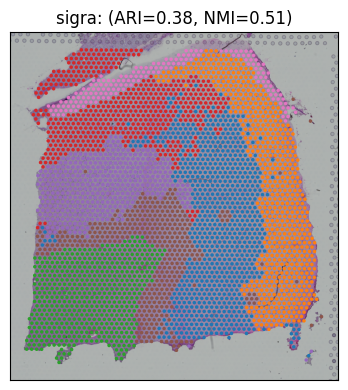

<Figure size 640x480 with 0 Axes>

In [161]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))

# 绘制空间数据并指定轴对象
sc.pl.spatial(
    adata,
    color="sigra",
    title=('sigra: (ARI=%.2f, NMI=%.2f)' % (ARI, NMI)),
    ax=axs,
    show=False,
    legend_loc=None
)
axs.set_xlabel('')
axs.set_ylabel('')
plt.tight_layout() 
output_dir = ('./ARI_NMI')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, f"{sample_name}_ARI.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()
plt.clf()
plt.close(fig)